# Mise en place du notebook

## Import des modules

In [1]:
# pour développement
from pympler import asizeof
import mesfonctions
from importlib import reload
mesfonctions = reload(mesfonctions)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.colors import LinearSegmentedColormap
from pandas_profiling import ProfileReport
from dataprep.eda import create_report
from sklearn import decomposition
from sklearn import preprocessing
from mesfonctions import display_scree_plot
from mesfonctions import display_circles
from mesfonctions import display_factorial_planes
import pickle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

NumExpr defaulting to 8 threads.


## Fonctions courantes

In [3]:
def filtre_dataframe_par_periode(df, colonnes, debut_periode, fin_periode):
    """ Filtre le dataframe avec le critère : 
    debut_periode < df['order_purchase_timestamp'] < fin_periode
    Args :
    - df : dataframe pandas à filtrer
    - colonnes : string ou liste de strings ; colonnes à conserver
    - debut_periode : Dtype timedelta64[ns]
    - fin_periode : Dtype timedelta64[ns]
    Returns : 
    - dataframe pandas filtré.
    """
    ser_bool = (df['order_purchase_timestamp'] >
                debut_periode) \
        & (df['order_purchase_timestamp'] < fin_periode)
    return df[colonnes][ser_bool]

## Constantes

In [4]:
# affichage des analyses exploratoires systématiques (dataprep)
# mettre True pour faire les analyses.
# Mettre False pour une sauvegarde du notebook \
# sinon la taille devient trop importante
BOOL_EDA = False

# les 6 trimestres pour les tests de stabilité
DEBUT_TRIMESTRE_1 = pd.to_datetime("2017-2-25")
FIN_TRIMESTRE_1 = pd.to_datetime("2017-5-25")
FIN_TRIMESTRE_2 = pd.to_datetime("2017-8-25")
FIN_TRIMESTRE_3 = pd.to_datetime("2017-11-25")
FIN_TRIMESTRE_4 = pd.to_datetime("2018-2-25")
FIN_TRIMESTRE_5 = pd.to_datetime("2018-5-25")
FIN_TRIMESTRE_6 = pd.to_datetime("2018-8-25")
DATES = [
    DEBUT_TRIMESTRE_1, FIN_TRIMESTRE_1, FIN_TRIMESTRE_2, FIN_TRIMESTRE_3,
    FIN_TRIMESTRE_4, FIN_TRIMESTRE_5, FIN_TRIMESTRE_6
]

# palettes de couleurs
colors = ["red", "green", "blue", "yellow", "black", "pink"]
CMAP5 = LinearSegmentedColormap.from_list("_", colors[:5])
CMAP6 = LinearSegmentedColormap.from_list("_", colors[:6])

## Gestion des paramètres d'affichage de Jupyter

In [5]:
from IPython.core.display import HTML
plt.style.use('seaborn')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

# Notes

## Olist

https://olist.com/faq/  
Société qui permet aux vendeurs e-commerce de vendre sur des "market place" (Amazon et autres).  
Sté implantée au Brésil, de type SaaS (Software as a Service).  
Pas de stock, pas d'entrepôt.  
"lorsque vous enregistrez votre produit sur notre plateforme, nous nous chargeons de le publier sur Mercado Livre, Americanas, Amazon et d'autres canaux. Vous n'avez pas besoin d'aller site par site, de créer un compte et de télécharger produit par produit."  
"la gestion des ventes avec la boutique olist est également beaucoup plus simple, car toutes les commandes sont centralisées sur notre plateforme, sans avoir besoin d'accéder à d'autres pages."  
" la différence entre s'inscrire dans la boutique olist et sur d'autres places de marché est la praticité . "  


Prestations offertes par Olist :  
- référencement / réputation.
- rédaction/ amélioration d'annonces 
- trouver le prix optimum de vente
- solutions logistiques
- suivi des ventes

Exemple de clients : LVMH, Chicco, Calvin Klein


## Traductions

boleto = paiement par chèque

## Dataset

### Olist dataset

https://www.kaggle.com/olistbr/brazilian-ecommerce

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.
    

### Métadonnées

https://www.kaggle.com/olistbr/brazilian-ecommerce

###### Customers Dataset

This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.

###### Geolocation Dataset

This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.

###### Order Items Dataset

This dataset includes data about the items purchased within each order.

###### Payments Dataset

This dataset includes data about the orders payment options.

###### Order Reviews Dataset

This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

###### Order Dataset

This is the core dataset. From each order you might find all other information.  
order_delivered_carrier_date : c'est la date à laquelle l'ordre a été expédié

###### Products Dataset

This dataset includes data about the products sold by Olist.

###### Sellers Dataset

This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.

###### Category Name Translation

Translates the productcategoryname to english.

### Marketing funnel

https://www.kaggle.com/olistbr/marketing-funnel-olist/home  

## Data Schema

The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it:

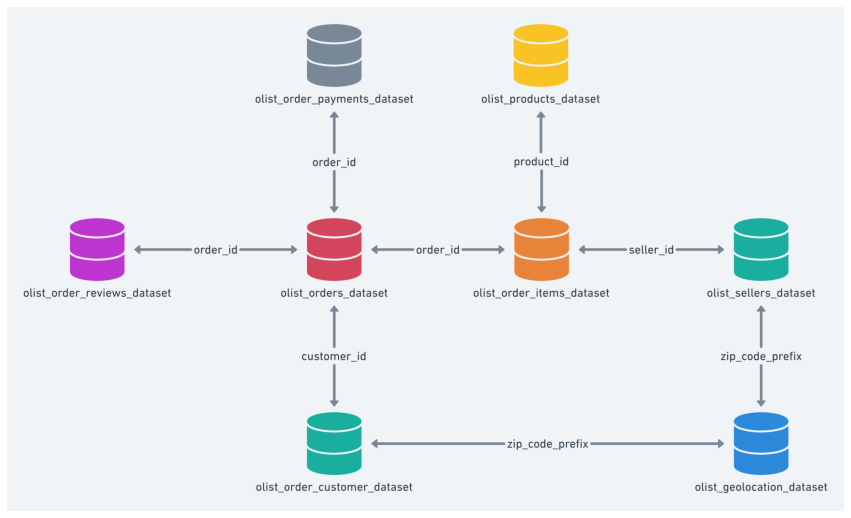

In [6]:
image_data_schema = img.imread('https://i.imgur.com/HRhd2Y0.png')
plt.figure(figsize=(15, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(image_data_schema)
plt.show()

## Marketing

### Segmentation RFM

https://www.definitions-marketing.com/definition/segmentation-rfm/

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

### Plan d'action marketing

https://www.qualtrics.com/fr/gestion-de-l-experience/etude-marche/segmentation-marketing/

# Récupération des données

## df_customers

In [7]:
df_customers = pd.read_csv('olist_customers_dataset.csv',
                           sep=',',
                           low_memory=False)

In [8]:
df_customers

customer_id                       customer_unique_id                 \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix customer_city          customer_state  
0      14409                                    franca  SP             
1       9790                     sao bernardo do campo  SP             
2       1151                                 sao paulo  SP             
3       8775                           mogi das cruzes  SP             
4      13056                                  campinas  SP             
...                         ...                    ...            ...  
99436   3937                                 sao paulo  SP             
99437   6764                           taboao da serra  SP             
99438  60115                                 fortaleza  CE             
99439  92120                                    canoas  RS             
99440   6703                                     cotia  SP             

[99441 rows x 5 columns]

In [9]:
report = BOOL_EDA
if report:
    report = ProfileReport(
        df_customers, title='df_customers Pandas Profiling Report', minimal=True)
report

False

In [10]:
report = BOOL_EDA
report = False
if report:
    # , config={"insight.skewed.threshold": 1e-5})
    report = create_report(df_customers)
report

False

In [11]:
print("Nombre de clients uniques :", len(
    df_customers['customer_unique_id'].unique()))

Nombre de clients uniques : 96096


## df_geolocation

In [12]:
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv',
                             sep=',',
                             low_memory=False)

In [13]:
df_geolocation.sort_values('geolocation_zip_code_prefix')

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
1246      1001                       -23.549292       -46.633559         
429       1001                       -23.550498       -46.634338         
1182      1001                       -23.549779       -46.633957         
1435      1001                       -23.549292       -46.633559         
326       1001                       -23.551427       -46.634074         
...                              ...              ...              ...   
1000026  99980                       -28.388679       -51.848863         
999950   99980                       -28.388400       -51.845225         
1000002  99980                       -28.388342       -51.845194         
999864   99990                       -28.329472       -51.769109         
999758   99990                       -28.329718       -51.769615         

        geolocation_city geolocation_state  
1246           sao paulo  SP                
429            sao paulo  SP                
1182           sao paulo  SP                
1435           sao paulo  SP                
326            sao paulo  SP                
...                  ...               ...  
1000026  david canabarro  RS                
999950   david canabarro  RS                
1000002  david canabarro  RS                
999864         muliterno  RS                
999758         muliterno  RS                

[1000163 rows x 5 columns]

In [14]:
report = BOOL_EDA
# report = True
if report:
    report = ProfileReport(df_geolocation,
                           title='df_geolocation Pandas Profiling Report',
                           minimal=True)
report

False

### Nettoyage du dataset geolocation

Les zip codes contiennent une multitude de données de longitude/latitude très proches. En pratique, ça revient à des doublons.  
On simplifie ce dataset en supprimant les lignes de zip codes en trop.

In [15]:
df_geolocation = df_geolocation.copy().drop_duplicates(
    subset='geolocation_zip_code_prefix', keep='first', inplace=False)
df_geolocation

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0        1037                       -23.545621       -46.639292         
1        1046                       -23.546081       -46.644820         
3        1041                       -23.544392       -46.639499         
4        1035                       -23.541578       -46.641607         
5        1012                       -23.547762       -46.635361         
...                             ...              ...              ...   
999774  99955                       -28.107588       -52.144019         
999780  99970                       -28.345143       -51.876926         
999786  99910                       -27.863500       -52.084760         
999803  99920                       -27.858716       -52.300403         
999846  99952                       -28.160371       -51.936922         

       geolocation_city      geolocation_state  
0                  sao paulo  SP                
1                  sao paulo  SP                
3                  sao paulo  SP                
4                  sao paulo  SP                
5                  são paulo  SP                
...                      ...               ...  
999774          vila langaro  RS                
999780               ciriaco  RS                
999786      floriano peixoto  RS                
999803              erebango  RS                
999846  santa cecilia do sul  RS                

[19015 rows x 5 columns]

In [16]:
df_geolocation['geolocation_zip_code_prefix'].unique().shape

(19015,)

## df_items

In [17]:
df_items = pd.read_csv('olist_order_items_dataset.csv',
                       sep=',',
                       low_memory=False)

In [18]:
df_items.head(20)

order_id                           order_item_id  \
0   00010242fe8c5a6d1ba2dd792cb16214  1               
1   00018f77f2f0320c557190d7a144bdd3  1               
2   000229ec398224ef6ca0657da4fc703e  1               
3   00024acbcdf0a6daa1e931b038114c75  1               
4   00042b26cf59d7ce69dfabb4e55b4fd9  1               
5   00048cc3ae777c65dbb7d2a0634bc1ea  1               
6   00054e8431b9d7675808bcb819fb4a32  1               
7   000576fe39319847cbb9d288c5617fa6  1               
8   0005a1a1728c9d785b8e2b08b904576c  1               
9   0005f50442cb953dcd1d21e1fb923495  1               
10  00061f2a7bc09da83e415a52dc8a4af1  1               
11  00063b381e2406b52ad429470734ebd5  1               
12  0006ec9db01a64e59a68b2c340bf65a7  1               
13  0008288aa423d2a3f00fcb17cd7d8719  1               
14  0008288aa423d2a3f00fcb17cd7d8719  2               
15  0009792311464db532ff765bf7b182ae  1               
16  0009c9a17f916a706d71784483a5d643  1               
17  000aed2e25dbad2f9ddb70584c5a2ded  1               
18  000c3e6612759851cc3cbb4b83257986  1               
19  000e562887b1f2006d75e0be9558292e  1               

   product_id                        seller_id                          \
0   4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1   e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2   c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3   7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4   ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
5   ef92defde845ab8450f9d70c526ef70f  6426d21aca402a131fc0a5d0960a3c90   
6   8d4f2bb7e93e6710a28f34fa83ee7d28  7040e82f899a04d1b434b795a43b4617   
7   557d850972a7d6f792fd18ae1400d9b6  5996cddab893a4652a15592fb58ab8db   
8   310ae3c140ff94b03219ad0adc3c778f  a416b6a846a11724393025641d4edd5e   
9   4535b0e1091c278dfd193e5a1d63b39f  ba143b05f0110f0dc71ad71b4466ce92   
10  d63c1011f49d98b976c352955b1c4bea  cc419e0650a3c5ba77189a1882b7556a   
11  f177554ea93259a5b282f24e33f65ab6  8602a61d680a10a82cceeeda0d99ea3d   
12  99a4788cb24856965c36a24e339b6058  4a3ca9315b744ce9f8e9374361493884   
13  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
14  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
15  8cab8abac59158715e0d70a36c807415  530ec6109d11eaaf87999465c6afee01   
16  3f27ac8e699df3d300ec4a5d8c5cf0b2  fcb5ace8bcc92f75707dc0f01a27d269   
17  4fa33915031a8cde03dd0d3e8fb27f01  fe2032dab1a61af8794248c8196565c9   
18  b50c950aba0dcead2c48032a690ce817  218d46b86c1881d022bce9c68a7d4b15   
19  5ed9eaf534f6936b51d0b6c5e4d5c2e9  8cbac7e12637ed9cffa18c7875207478   

   shipping_limit_date   price   freight_value  
0   2017-09-19 09:45:35   58.90  13.29          
1   2017-05-03 11:05:13  239.90  19.93          
2   2018-01-18 14:48:30  199.00  17.87          
3   2018-08-15 10:10:18   12.99  12.79          
4   2017-02-13 13:57:51  199.90  18.14          
5   2017-05-23 03:55:27   21.90  12.69          
6   2017-12-14 12:10:31   19.90  11.85          
7   2018-07-10 12:30:45  810.00  70.75          
8   2018-03-26 18:31:29  145.95  11.65          
9   2018-07-06 14:10:56   53.99  11.40          
10  2018-03-29 22:28:09   59.99   8.88          
11  2018-07-31 17:30:39   45.00  12.98          
12  2018-07-26 17:24:20   74.00  23.32          
13  2018-02-21 02:55:52   49.90  13.37          
14  2018-02-21 02:55:52   49.90  13.37          
15  2018-08-17 12:15:10   99.90  27.65          
16  2018-05-02 09:31:53  639.00  11.34          
17  2018-05-16 20:57:03  144.00   8.77          
18  2017-08-21 03:33:13   99.00  13.71          
19  2018-02-28 12:08:37   25.00  16.11

In [19]:
report = BOOL_EDA
if report:
    report = ProfileReport(df_items,
                           title='df_items Pandas Profiling Report',
                           minimal=True)
report

False

In [20]:
report = BOOL_EDA
# report = False
if report:
    report = create_report(df_items)
report

False

## df_payments

In [21]:
df_payments_csv = pd.read_csv('olist_order_payments_dataset.csv',
                              sep=',',
                              low_memory=False)

In [22]:
df_payments_csv

order_id                           payment_sequential payment_type  \
0       b81ef226f3fe1789b1e8b2acac839d17  1                   credit_card   
1       a9810da82917af2d9aefd1278f1dcfa0  1                   credit_card   
2       25e8ea4e93396b6fa0d3dd708e76c1bd  1                   credit_card   
3       ba78997921bbcdc1373bb41e913ab953  1                   credit_card   
4       42fdf880ba16b47b59251dd489d4441a  1                   credit_card   
...                                  ...                 ...          ...   
103881  0406037ad97740d563a178ecc7a2075c  1                        boleto   
103882  7b905861d7c825891d6347454ea7863f  1                   credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf  1                   credit_card   
103884  b8b61059626efa996a60be9bb9320e10  1                   credit_card   
103885  28bbae6599b09d39ca406b747b6632b1  1                        boleto   

        payment_installments  payment_value  
0       8                      99.33         
1       1                      24.39         
2       1                      65.71         
3       8                     107.78         
4       2                     128.45         
...                      ...            ...  
103881  1                     363.31         
103882  2                      96.80         
103883  1                      47.77         
103884  5                     369.54         
103885  1                     191.58         

[103886 rows x 5 columns]

Pourquoi la taille de df_payments est supérieure à celle de df_order ?  
L'explication est que ces paiements multiples sont souvent liés à des vouchers.  
En revanche lorsque payment_installments > 1, ces paiements n'occupent qu'une seule ligne dans df_payments

In [23]:
# on affiche les order_id en doublons
ser_bool_duplicated = df_payments_csv['order_id'].duplicated(keep=False)
df_payments_csv[ser_bool_duplicated].sort_values(
    by=['order_id', 'payment_sequential']).head(100)

order_id                           payment_sequential payment_type  \
89575   0016dfedd97fc2950e388d2971d718c7  1                   credit_card   
80856   0016dfedd97fc2950e388d2971d718c7  2                       voucher   
20036   002f19a65a2ddd70a090297872e6d64e  1                       voucher   
98894   002f19a65a2ddd70a090297872e6d64e  2                       voucher   
10244   0071ee2429bc1efdc43aa3e073a5290e  1                       voucher   
30155   0071ee2429bc1efdc43aa3e073a5290e  2                       voucher   
16053   009ac365164f8e06f59d18a08045f6c4  1                   credit_card   
16459   009ac365164f8e06f59d18a08045f6c4  2                       voucher   
73837   009ac365164f8e06f59d18a08045f6c4  3                       voucher   
32058   009ac365164f8e06f59d18a08045f6c4  4                       voucher   
285     009ac365164f8e06f59d18a08045f6c4  5                       voucher   
15298   009ac365164f8e06f59d18a08045f6c4  6                       voucher   
59042   00b4a910f64f24dbcac04fe54088a443  1                   credit_card   
12874   00b4a910f64f24dbcac04fe54088a443  2                       voucher   
34559   00bd50cdd31bd22e9081e6e2d5b3577b  1                   credit_card   
20650   00bd50cdd31bd22e9081e6e2d5b3577b  2                       voucher   
8869    00bd50cdd31bd22e9081e6e2d5b3577b  3                       voucher   
67123   00c405bd71187154a7846862f585a9d4  1                   credit_card   
54653   00c405bd71187154a7846862f585a9d4  2                       voucher   
60979   00c405bd71187154a7846862f585a9d4  3                       voucher   
76930   00c405bd71187154a7846862f585a9d4  4                       voucher   
52049   00c405bd71187154a7846862f585a9d4  5                       voucher   
26391   00c405bd71187154a7846862f585a9d4  6                       voucher   
20594   00c405bd71187154a7846862f585a9d4  7                       voucher   
12201   00c95282163553a982f38481f9488481  1                   credit_card   
72814   00c95282163553a982f38481f9488481  2                       voucher   
60372   00c95282163553a982f38481f9488481  3                       voucher   
34579   00c95282163553a982f38481f9488481  4                       voucher   
24134   00e6bc6b166eb28b4502c1cad4457248  1                   credit_card   
80236   00e6bc6b166eb28b4502c1cad4457248  2                       voucher   
63471   013037c3f1773cc8fdbaf8ff54d8013b  1                   credit_card   
70954   013037c3f1773cc8fdbaf8ff54d8013b  2                       voucher   
101820  01358622f65717728b3b2ec2cf4e8812  1                   credit_card   
49201   01358622f65717728b3b2ec2cf4e8812  2                   credit_card   
36383   013bc77d3ca5fba084a241fdcb307393  1                       voucher   
6642    013bc77d3ca5fba084a241fdcb307393  2                       voucher   
49011   0216ea85f929ce4795f933573c6bb055  1                       voucher   
46625   0216ea85f929ce4795f933573c6bb055  2                       voucher   
17931   0218c7a4fb8d5b1bd22c82b783b8359c  1                   credit_card   
92679   0218c7a4fb8d5b1bd22c82b783b8359c  2                       voucher   
10551   02725851051698269253f0823e7824b6  1                   credit_card   
24253   02725851051698269253f0823e7824b6  2                       voucher   
28716   028369515408fa864cfe50091d4e76c5  1                   credit_card   
43051   028369515408fa864cfe50091d4e76c5  2                       voucher   
82371   02950daa1214da108fb29cb5a0a3f74e  1                       voucher   
103435  02950daa1214da108fb29cb5a0a3f74e  2                       voucher   
99441   02d0cd05f04ab2e3c1acc473b0abc865  1                   credit_card   
79945   02d0cd05f04ab2e3c1acc473b0abc865  2                   credit_card   
3876    02dbd29bc7a490d582762fae9f0fd997  1                   credit_card   
18853   02dbd29bc7a490d582762fae9f0fd997  2                       voucher   
68931   02ec4da9d03014f06d711d60eb37cc22  1                   credit_card   
326

In [24]:
report = BOOL_EDA
if report:
    report = ProfileReport(df_payments,
                           title='df_payments Pandas Profiling Report',
                           minimal=True)
report

False

### Variable payment_value_order

Le format du dataset "payments" est peu pratique. 
Il sépare en plusieurs "payment_sequential" lorsqu'un ordre est payé avec différents moyens de paiements (typiquement plusieurs vouchers).  
Il est plus pratique de regrouper les différentes valeurs de "payment_value" d'un même ordre en un seul paiment : c'est pourquoi la variable "payment_value_order" a été créée.

In [25]:
# groupby sur customer_unique_id, puis calcul du count() pour chaque groupe
df = df_payments_csv.groupby('order_id', sort=False).sum()
df.drop(columns=['payment_sequential'], inplace=True)
df.rename(columns={'payment_value': 'payment_value_order'}, inplace=True)
df

payment_installments  payment_value_order
order_id                                                                   
b81ef226f3fe1789b1e8b2acac839d17  8                      99.33             
a9810da82917af2d9aefd1278f1dcfa0  1                      24.39             
25e8ea4e93396b6fa0d3dd708e76c1bd  1                      65.71             
ba78997921bbcdc1373bb41e913ab953  8                     107.78             
42fdf880ba16b47b59251dd489d4441a  2                     128.45             
...                                                ...                  ...
0406037ad97740d563a178ecc7a2075c  1                     363.31             
7b905861d7c825891d6347454ea7863f  2                      96.80             
32609bbb3dd69b3c066a6860554a77bf  1                      47.77             
b8b61059626efa996a60be9bb9320e10  5                     369.54             
28bbae6599b09d39ca406b747b6632b1  1                     191.58             

[99440 rows x 2 columns]

Note : à 1 près on retrouve les 99441 ordres du dataset "orders".

In [26]:
# on teste la valeur de la variable payment_value_sum pour un ordre payé en 2 parties (voucher + CB).
df[df.index == '0016dfedd97fc2950e388d2971d718c7']

payment_installments  payment_value_order
order_id                                                                   
0016dfedd97fc2950e388d2971d718c7  6                     70.55

Pour l'ordre '0016dfedd97fc2950e388d2971d718c7', les 6 payment_installments correspondent à 1 voucher et 5 installments de credit card.

In [27]:
# on remplace df_payments par le nouveau df
df_payments = df.copy()

## df_reviews

In [28]:
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv',
                         sep=',',
                         low_memory=False)

In [29]:
df_reviews

review_id                         order_id                           \
0      7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1      80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2      228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3      e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4      f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
...                                 ...                               ...   
99995  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
99996  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99997  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
99998  be360f18f5df1e0541061c87021e6d93  f8bd3f2000c28c5342fedeb5e50f2e75   
99999  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score review_comment_title  \
0      4             NaN                   
1      5             NaN                   
2      5             NaN                   
3      5             NaN                   
4      5             NaN                   
...             ...                  ...   
99995  5             NaN                   
99996  5             NaN                   
99997  4             NaN                   
99998  1             NaN                   
99999  1             NaN                   

      review_comment_message                             review_creation_date  \
0                                                    NaN  2018-01-18 00:00:00   
1                                                    NaN  2018-03-10 00:00:00   
2                                                    NaN  2018-02-17 00:00:00   
3                  Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4      Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
...                                                  ...                  ...   
99995                                                NaN  2017-12-09 00:00:00   
99996  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99997                                                NaN  2018-07-01 00:00:00   
99998  Solicitei a compra de uma capa de retrovisor c...  2017-12-15 00:00:00   
99999  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
0      2018-01-18 21:46:59     
1      2018-03-11 03:05:13     
2      2018-02-18 14:36:24     
3      2017-04-21 22:02:06     
4      2018-03-02 10:26:53     
...                       ...  
99995  2017-12-11 20:06:42     
99996  2018-03-23 09:10:43     
99997  2018-07-02 12:59:13     
99998  2017-12-16 01:29:43     
99999  2017-07-03 21:01:49     

[100000 rows x 7 columns]

In [30]:
report = BOOL_EDA
if report:
    report = ProfileReport(df_reviews,
                           title='df_reviews Pandas Profiling Report',
                           minimal=True)
report

False

In [31]:
with pd.option_context('display.max_colwidth', 1000):
    display(df_reviews[['review_score', 'review_comment_message']].sample(20))

review_score  \
46160  5              
57942  4              
80015  3              
99631  5              
44964  5              
57994  5              
54413  5              
92546  5              
73553  5              
2638   5              
23440  4              
37181  5              
4953   1              
89786  4              
68490  5              
41344  5              
92005  4              
8065   5              
17767  5              
66176  1              

      review_comment_message                                                                        
46160                                                                                          NaN  
57942                                                                                          NaN  
80015                                                                                          NaN  
99631                                                                                          NaN  
44964                                                                                          NaN  
57994                                                                  Gostei muito do atendimento  
54413                                                                                          NaN  
92546                                                                                          NaN  
73553  Gostei de comprar com este vendedor, chegou no prazo emuito bem embalado, recomendo muito.   
2638                                                                                           NaN  
23440                                                                                          NaN  
37181                                                                                   Recomendo   
4953                                                                                           NaN  
89786                                                                                          NaN  
68490                                                                                          NaN  
41344                                                                                          NaN  
92005                                                                                          NaN  
8065                                                      Produto chegou bem antes do prazo final.  
17767                                                                                          NaN  
66176                                                             Relogios falsificado não gostei

Les reviews sont rattachées à des orders (et pas à des products commandés comme c'est l'usage).  
De nombreux ordres ont des reviews en doublon :  
\- souvent deux fois la même note, et pas de commentaire.  
\- souvent deux mauvaises notes (d'abord une mauvaise, puis une très mauvaise), avec des commentaires liés à des pb de livraison.  

Cf extrait ci-dessous des ordres avec des reviews multiples :

In [32]:
with pd.option_context('display.max_colwidth', 1000):
    ser_bool_duplicated = df_reviews['order_id'].duplicated(keep=False)
    display(df_reviews[ser_bool_duplicated].sort_values(
        by=['order_id', 'review_answer_timestamp'])[[
            'order_id', 'review_answer_timestamp', 'review_score',
            'review_comment_message'
        ]].head(100))

order_id                          review_answer_timestamp  review_score  \
22585  0035246a40f520710769010f752e7507  2017-08-29 21:45:57     5              
25802  0035246a40f520710769010f752e7507  2017-08-30 01:59:12     5              
22946  013056cfe49763c6f66bda03396c5ee3  2018-02-23 12:12:30     5              
69191  013056cfe49763c6f66bda03396c5ee3  2018-03-05 17:02:00     4              
857    0176a6846bcb3b0d3aa3116a9a768597  2018-01-02 10:54:06     5              
83893  0176a6846bcb3b0d3aa3116a9a768597  2018-01-02 10:54:47     5              
90601  02355020fd0a40a0d56df9f6ff060413  2018-03-22 01:32:08     3              
17708  02355020fd0a40a0d56df9f6ff060413  2018-03-30 03:16:19     1              
38195  029863af4b968de1e5d6a82782e662f5  2017-07-17 13:58:06     5              
55564  029863af4b968de1e5d6a82782e662f5  2017-07-20 12:06:11     4              
17975  02e0b68852217f5715fb9cc885829454  2017-12-03 21:56:37     4              
36081  02e0b68852217f5715fb9cc885829454  2017-12-03 21:57:31     4              
42826  02e723e8edb4a123d414f56cc9c4665e  2017-09-02 12:13:03     5              
35313  02e723e8edb4a123d414f56cc9c4665e  2017-09-05 12:12:51     5              
50019  03515a836bb855b03f7df9dee520a8fc  2018-02-01 01:26:24     5              
38672  03515a836bb855b03f7df9dee520a8fc  2018-02-06 17:19:21     5              
70005  03c939fd7fd3b38f8485a0f95798f1f6  2018-03-06 19:50:32     3              
8329   03c939fd7fd3b38f8485a0f95798f1f6  2018-03-21 02:28:23     3              
51931  03c939fd7fd3b38f8485a0f95798f1f6  2018-03-30 00:29:09     4              
89328  03eba6d9fef8f5b3e811d4b5a7cca9cd  2018-02-23 23:55:53     4              
93611  03eba6d9fef8f5b3e811d4b5a7cca9cd  2018-03-09 00:09:40     5              
45460  04f1827088d972a62224f5203a071500  2018-01-03 10:40:06     5              
43434  04f1827088d972a62224f5203a071500  2018-01-07 11:14:04     1              
49464  0544030711e50ec2cb6c15764d22891a  2018-05-04 11:29:18     4              
79672  0544030711e50ec2cb6c15764d22891a  2018-05-04 17:54:45     1              
48051  05452881e2846549b81d39249bb66ad7  2018-02-10 16:50:27     5              
33283  05452881e2846549b81d39249bb66ad7  2018-02-25 04:09:03     5              
23509  056bfadd41b8600ad5ecfef2ac132188  2017-12-09 13:53:28     4              
57030  056bfadd41b8600ad5ecfef2ac132188  2017-12-09 13:53:55     4              
15893  059bbeb3477ed66fd7e670c3f879009a  2017-08-01 20:39:04     2              
9205   059bbeb3477ed66fd7e670c3f879009a  2017-08-04 09:32:59     5              
21050  06b2c7035561ef12b16045ef4bf459e2  2017-07-18 00:24:04     5              
76971  06b2c7035561ef12b16045ef4bf459e2  2017-07-27 16:35:51     5              
1917   0715dfcf2383aa72c181d8b47f6cb589  2018-03-06 23:17:46     5              
10652  0715dfcf2383aa72c181d8b47f6cb589  2018-03-10 20:42:13     5              
90468  073fa4be4665f397a289842b1053229c  2018-01-24 20:26:57     5              
65716  073fa4be4665f397a289842b1053229c  2018-01-25 10:01:21     1              
39231  0749426d1c48fe5943cbdf1316ace0aa  2018-02-10 12:48:27     1              
41749  0749426d1c48fe5943cbdf1316ace0aa  2018-02-10 12:55:50     1              
53980  075a544c5f4ed4bb75f82b160465fe76  2018-03-07 12:32:38     3              
89588  075a544c5f4ed4bb75f82b160465fe76  2018-03-17 19:39:26     1              
53659  076d991923ee938761994a4255f5c5da  2017-12-24 12:15:37     5              
1751   076d991923ee938761994a4255f5c5da  2017-12-31 12:26:08     5              
42819  08bf75dcf867b9f13026785053e87052  2017-08-28 18:38:22     5              
66259  08bf75dcf867b9f13026785053e87052  2017-09-03 20:40:39     3              
45386  08c01d43e93f5c485f48758550d41eb9  2017-05-22 19:15:36     1              
98295  08c01d43e93f5c485f48758550d41eb9  2017-05-22 19:19:11     1              
55714  095e9e0811476409362d72fa70d73a6c  2018-02-21 02:51:10     3              
61042  095e9e0811476409362d72fa70d73a

### Nettoyage du dataset reviews

Pour un order ayant plusieurs reviews, on ne garde que la review la plus récente, car elle correspond au dernier avis du client pour cet ordre.  

In [33]:
df_reviews.sort_values(by=['order_id', 'review_answer_timestamp']).head(100)

review_id                         order_id                           \
52372  97ca439bc427b48bc1cd7177abe71365  00010242fe8c5a6d1ba2dd792cb16214   
28025  7b07bacd811c4117b742569b04ce3580  00018f77f2f0320c557190d7a144bdd3   
4244   0c5b33dea94867d1ac402749e5438e8b  000229ec398224ef6ca0657da4fc703e   
39133  f4028d019cb58564807486a6aaf33817  00024acbcdf0a6daa1e931b038114c75   
56106  940144190dcba6351888cafa43f3a3a5  00042b26cf59d7ce69dfabb4e55b4fd9   
22900  5e4e50af3b7960b7a10d86ec869509e8  00048cc3ae777c65dbb7d2a0634bc1ea   
93917  0381de7572d99d75230ce91207807265  00054e8431b9d7675808bcb819fb4a32   
90759  f0733ebeb51b637dfdc953983c867b89  000576fe39319847cbb9d288c5617fa6   
68349  67b1ab8f3ec19d5a90f153f21757d3a1  0005a1a1728c9d785b8e2b08b904576c   
36252  5c0b7e34ed85ec659bb064902d878e7a  0005f50442cb953dcd1d21e1fb923495   
24922  7e92c32ae297ef950ee69781d9f1760c  00061f2a7bc09da83e415a52dc8a4af1   
94462  5595c192e3c1566ab4e7a2748b8ed297  00063b381e2406b52ad429470734ebd5   
57482  6322c405c0f34bf3ad870fd1a6b1fced  0006ec9db01a64e59a68b2c340bf65a7   
15366  5505c1cce299b1e0b3f8e4b428417362  0008288aa423d2a3f00fcb17cd7d8719   
66403  236ccf78a5c4c350c18fdc1ae12b0187  0009792311464db532ff765bf7b182ae   
27496  787a452b54147f8f64737b1e040234af  0009c9a17f916a706d71784483a5d643   
96480  00800678dcf28b0ea0caef2147b6945d  000aed2e25dbad2f9ddb70584c5a2ded   
19788  51b9186876d4708a91786f8517fe7106  000c3e6612759851cc3cbb4b83257986   
27406  3b9a423bdbe8734ddfeb09bced16e5d9  000e562887b1f2006d75e0be9558292e   
58600  06f45fcd8b9b54c30b0de110eb849228  000e63d38ae8c00bbcb5a30573b99628   
81698  a5fb93d6a9e707bd84c07da74e8d79fd  000e906b789b55f64edcb1f84030f90d   
69544  775038877f3c507777081ff685e14a60  000f25f4d72195062c040b12dce9a18a   
62820  fa2d523cc60173d4889520763a2e4851  001021efaa8636c29475e7734483457d   
70231  f55e59915a07435c3615737a15470d96  0010b2e5201cc5f1ae7e9c6cc8f5bd00   
50159  d5d01007883616401b65674911160c82  0010dedd556712d7bb69a19cb7bbd37a   
94498  e79b1300216401c0212ab9b5a66372ff  00119ff934e539cf26f92b9ef0cdfed8   
80430  04a15fdeccc0572ca4f52b16cd50408a  0011d82c4b53e22e84023405fb467e57   
17808  08af1a16cca5edd546f4a10b6e87af2e  00125cb692d04887809806618a2a145f   
10363  4ff9a24999699f7104ed23fec2563351  00130c0eee84a3d909e75bc08c5c3ca1   
6801   b5c9aa83935388c89bd9b1b2ce6d1439  0013503b13da1eac686219390b7d641b   
11489  fe1711409007a1243f6fa3a1118d416c  00137e170939bba5a3134e2386413108   
43541  174a50ecc3181301a3585ff14ab5f98b  001427c0ec99cf8af737bd88e92fd444   
97667  29ae131f1e1b52d81fb3ff6427ceb007  00143d0f86d6fbd9f9b38ab440ac16f5   
31626  81c4070474d420a77a2254b8a5473f6a  0014ae671de39511f7575066200733b7   
14371  282ec15daab81bd9afe2452fa0ee7b39  0015ebb40fb17286bea51d4607c4733c   
95672  28e20f3ef22e8795ea14e65f54e087a3  00169e31ef4b29deaae414f9a5e95929   
552    f11d548dc1a7c713bff0b6d2ef0dff7c  0016dfedd97fc2950e388d2971d718c7   
9365   f7bbac6b6901d7636435ea406a856e34  0017afd5076e074a48f1f1a4c7bac9c5   
6917   164fba09ca80765e400c72749b58c267  001862358bf858722e1e2ae000cfed8b   
76942  1e8067a9f38deb9426d4278fa2d213d0  0019c29108428acffd089c36103c9440   
22658  68b49cfcd9420c6ad09af97ea8268e7c  001ab0a7578dd66cd4b0a71f5b6e1e41   
66679  95ae5c0c6595c9f75ddc037cca0596ae  001ac194d4a326a6fa99b581e9a3d963   
73812  ed0405017b21b89fe55282aca123eeec  001b76dd48a5b1eee3e87778daa40df8   
14751  bef8f895661652ee0f5dbc2626864df3  001c85b5f68d2be0cb0797afc9e8ce9a   
80800  51ebb8fede4fbe6126f9f85ebdd23166  001d8f0e34a38c37f7dba2a37d4eba8b   
86013  df246bd48fbc0a0c9a7d4979c9192eec  001daeb0eddc45b999bad0801ad9d273   
68785  87d38823c8e926b57ec61e64f5466cfd  001dbc16dc51075e987543d23a0507c7   
50339  963e12d9a7c84e15c199bb5f062e599f  001e7ba991be1b19605ca0316e7130f9   
67070  048baba3f11436d12b06dab572aafc21  001e7cf2ad6bef3ade12ebc56ceaf0f3   
72234  1079dbb2bd2dd071f7d04a1925da6ce5  0020262c8a370bd5a174ea6a2a267321   
72289  ac2538373fcfab2aff0709fbc7ec69c9  0020a222f55eb79a372d0efee3cca688   
18

In [34]:
df_reviews = df_reviews.copy().sort_values(
    by=['order_id', 'review_answer_timestamp']).drop_duplicates(
        subset='order_id', keep='last', inplace=False)
df_reviews.head(100)

review_id                         order_id                           \
52372  97ca439bc427b48bc1cd7177abe71365  00010242fe8c5a6d1ba2dd792cb16214   
28025  7b07bacd811c4117b742569b04ce3580  00018f77f2f0320c557190d7a144bdd3   
4244   0c5b33dea94867d1ac402749e5438e8b  000229ec398224ef6ca0657da4fc703e   
39133  f4028d019cb58564807486a6aaf33817  00024acbcdf0a6daa1e931b038114c75   
56106  940144190dcba6351888cafa43f3a3a5  00042b26cf59d7ce69dfabb4e55b4fd9   
22900  5e4e50af3b7960b7a10d86ec869509e8  00048cc3ae777c65dbb7d2a0634bc1ea   
93917  0381de7572d99d75230ce91207807265  00054e8431b9d7675808bcb819fb4a32   
90759  f0733ebeb51b637dfdc953983c867b89  000576fe39319847cbb9d288c5617fa6   
68349  67b1ab8f3ec19d5a90f153f21757d3a1  0005a1a1728c9d785b8e2b08b904576c   
36252  5c0b7e34ed85ec659bb064902d878e7a  0005f50442cb953dcd1d21e1fb923495   
24922  7e92c32ae297ef950ee69781d9f1760c  00061f2a7bc09da83e415a52dc8a4af1   
94462  5595c192e3c1566ab4e7a2748b8ed297  00063b381e2406b52ad429470734ebd5   
57482  6322c405c0f34bf3ad870fd1a6b1fced  0006ec9db01a64e59a68b2c340bf65a7   
15366  5505c1cce299b1e0b3f8e4b428417362  0008288aa423d2a3f00fcb17cd7d8719   
66403  236ccf78a5c4c350c18fdc1ae12b0187  0009792311464db532ff765bf7b182ae   
27496  787a452b54147f8f64737b1e040234af  0009c9a17f916a706d71784483a5d643   
96480  00800678dcf28b0ea0caef2147b6945d  000aed2e25dbad2f9ddb70584c5a2ded   
19788  51b9186876d4708a91786f8517fe7106  000c3e6612759851cc3cbb4b83257986   
27406  3b9a423bdbe8734ddfeb09bced16e5d9  000e562887b1f2006d75e0be9558292e   
58600  06f45fcd8b9b54c30b0de110eb849228  000e63d38ae8c00bbcb5a30573b99628   
81698  a5fb93d6a9e707bd84c07da74e8d79fd  000e906b789b55f64edcb1f84030f90d   
69544  775038877f3c507777081ff685e14a60  000f25f4d72195062c040b12dce9a18a   
62820  fa2d523cc60173d4889520763a2e4851  001021efaa8636c29475e7734483457d   
70231  f55e59915a07435c3615737a15470d96  0010b2e5201cc5f1ae7e9c6cc8f5bd00   
50159  d5d01007883616401b65674911160c82  0010dedd556712d7bb69a19cb7bbd37a   
94498  e79b1300216401c0212ab9b5a66372ff  00119ff934e539cf26f92b9ef0cdfed8   
80430  04a15fdeccc0572ca4f52b16cd50408a  0011d82c4b53e22e84023405fb467e57   
17808  08af1a16cca5edd546f4a10b6e87af2e  00125cb692d04887809806618a2a145f   
10363  4ff9a24999699f7104ed23fec2563351  00130c0eee84a3d909e75bc08c5c3ca1   
6801   b5c9aa83935388c89bd9b1b2ce6d1439  0013503b13da1eac686219390b7d641b   
11489  fe1711409007a1243f6fa3a1118d416c  00137e170939bba5a3134e2386413108   
43541  174a50ecc3181301a3585ff14ab5f98b  001427c0ec99cf8af737bd88e92fd444   
97667  29ae131f1e1b52d81fb3ff6427ceb007  00143d0f86d6fbd9f9b38ab440ac16f5   
31626  81c4070474d420a77a2254b8a5473f6a  0014ae671de39511f7575066200733b7   
14371  282ec15daab81bd9afe2452fa0ee7b39  0015ebb40fb17286bea51d4607c4733c   
95672  28e20f3ef22e8795ea14e65f54e087a3  00169e31ef4b29deaae414f9a5e95929   
552    f11d548dc1a7c713bff0b6d2ef0dff7c  0016dfedd97fc2950e388d2971d718c7   
9365   f7bbac6b6901d7636435ea406a856e34  0017afd5076e074a48f1f1a4c7bac9c5   
6917   164fba09ca80765e400c72749b58c267  001862358bf858722e1e2ae000cfed8b   
76942  1e8067a9f38deb9426d4278fa2d213d0  0019c29108428acffd089c36103c9440   
22658  68b49cfcd9420c6ad09af97ea8268e7c  001ab0a7578dd66cd4b0a71f5b6e1e41   
66679  95ae5c0c6595c9f75ddc037cca0596ae  001ac194d4a326a6fa99b581e9a3d963   
73812  ed0405017b21b89fe55282aca123eeec  001b76dd48a5b1eee3e87778daa40df8   
14751  bef8f895661652ee0f5dbc2626864df3  001c85b5f68d2be0cb0797afc9e8ce9a   
80800  51ebb8fede4fbe6126f9f85ebdd23166  001d8f0e34a38c37f7dba2a37d4eba8b   
86013  df246bd48fbc0a0c9a7d4979c9192eec  001daeb0eddc45b999bad0801ad9d273   
68785  87d38823c8e926b57ec61e64f5466cfd  001dbc16dc51075e987543d23a0507c7   
50339  963e12d9a7c84e15c199bb5f062e599f  001e7ba991be1b19605ca0316e7130f9   
67070  048baba3f11436d12b06dab572aafc21  001e7cf2ad6bef3ade12ebc56ceaf0f3   
72234  1079dbb2bd2dd071f7d04a1925da6ce5  0020262c8a370bd5a174ea6a2a267321   
72289  ac2538373fcfab2aff0709fbc7ec69c9  0020a222f55eb79a372d0efee3cca688   
18

In [35]:
print("Nombre de lignes :", len(df_reviews))

Nombre de lignes : 99441


Bonne chose : on retrouve exactement le nombre de lignes de df_orders (99441).

## df_orders

In [36]:
df_orders = pd.read_csv('olist_orders_dataset.csv', sep=',', low_memory=False)

In [37]:
df_orders

order_id                          customer_id                        \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp order_approved_at     \
0      delivered    2017-10-02 10:56:33      2017-10-02 11:07:15   
1      delivered    2018-07-24 20:41:37      2018-07-26 03:24:27   
2      delivered    2018-08-08 08:38:49      2018-08-08 08:55:23   
3      delivered    2017-11-18 19:28:06      2017-11-18 19:45:59   
4      delivered    2018-02-13 21:18:39      2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436  delivered    2017-03-09 09:54:05      2017-03-09 09:54:05   
99437  delivered    2018-02-06 12:58:58      2018-02-06 13:10:37   
99438  delivered    2017-08-27 14:46:43      2017-08-27 15:04:16   
99439  delivered    2018-01-08 21:28:27      2018-01-08 21:36:21   
99440  delivered    2018-03-08 20:57:30      2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0      2017-10-04 19:55:00          2017-10-10 21:25:13            
1      2018-07-26 14:31:00          2018-08-07 15:27:45            
2      2018-08-08 13:50:00          2018-08-17 18:06:29            
3      2017-11-22 13:39:59          2017-12-02 00:28:42            
4      2018-02-14 19:46:34          2018-02-16 18:17:02            
...                            ...                           ...   
99436  2017-03-10 11:18:03          2017-03-17 15:08:01            
99437  2018-02-07 23:22:42          2018-02-28 17:37:56            
99438  2017-08-28 20:52:26          2017-09-21 11:24:17            
99439  2018-01-12 15:35:03          2018-01-25 23:32:54            
99440  2018-03-09 22:11:59          2018-03-16 13:08:30            

      order_estimated_delivery_date  
0      2017-10-18 00:00:00           
1      2018-08-13 00:00:00           
2      2018-09-04 00:00:00           
3      2017-12-15 00:00:00           
4      2018-02-26 00:00:00           
...                             ...  
99436  2017-03-28 00:00:00           
99437  2018-03-02 00:00:00           
99438  2017-09-27 00:00:00           
99439  2018-02-15 00:00:00           
99440  2018-04-03 00:00:00           

[99441 rows x 8 columns]

In [38]:
report = BOOL_EDA
# report = True
if report:
    report = ProfileReport(df_orders,
                           title='df_orders Pandas Profiling Report',
                           minimal=True)
report

False

### Conversion datetime

In [39]:
for var in [
        'order_purchase_timestamp', 'order_approved_at',
        'order_delivered_carrier_date', 'order_delivered_customer_date',
        'order_estimated_delivery_date'
]:
    df_orders[var] = pd.to_datetime(df_orders[var]).copy()

df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

### Somme cumulée des ordres en fonction de la date

In [40]:
print("Ordre le plus ancien du df :",
      df_orders['order_purchase_timestamp'].min())
print("Ordre le plus récent du df :",
      df_orders['order_purchase_timestamp'].max())

Ordre le plus ancien du df : 2016-09-04 21:15:19
Ordre le plus récent du df : 2018-10-17 17:30:18


Text(2018-08-30 00:00:00, 75000, '2018-8-25')

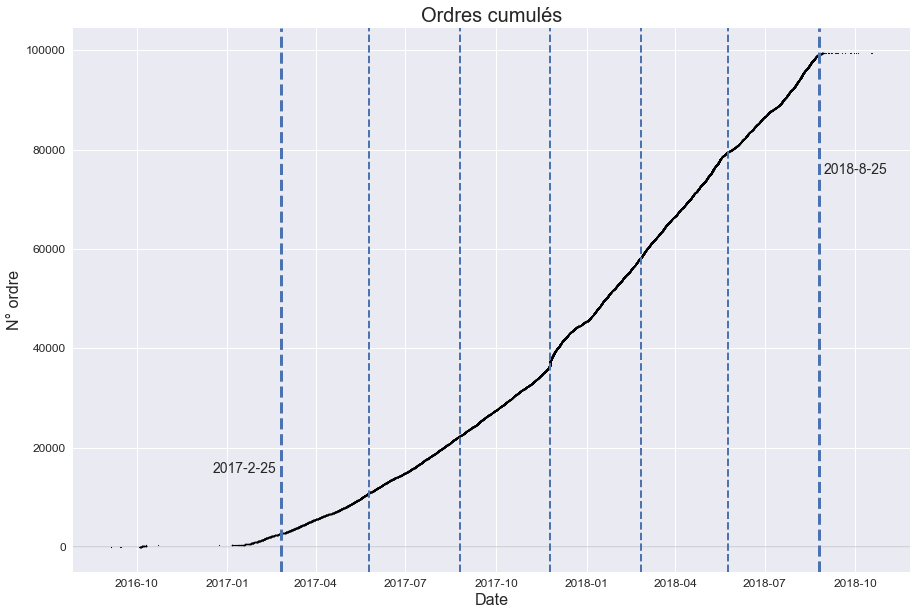

In [41]:
# Tracé cumulatif des ordres
ser = df_orders['order_purchase_timestamp'].sort_values()
ser.reset_index(drop=True, inplace=True)
plt.figure(figsize=(15, 10), edgecolor='k')
plt.scatter(ser, ser.index, s=0.6, c='k')
plt.xlabel('Date', size=16)
plt.ylabel('N° ordre', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Ordres cumulés', size=20)
plt.axhline(0, color='k', linewidth=0.2)

# Tracé des lignes verticales
plt.axvline(DEBUT_TRIMESTRE_1, linestyle='--', linewidth=3)
plt.axvline(FIN_TRIMESTRE_6, linestyle='--', linewidth=3)
for i in range(1, 6):
    nom_var = "récence_" + "fin_trimestre_" + str(i)
    fin_trimestre_i = globals()["FIN_TRIMESTRE_" + str(i)]
    plt.axvline(fin_trimestre_i, linestyle='--', linewidth=2)
timedelta = pd.Timedelta('5 days')
plt.annotate("2017-2-25", (DEBUT_TRIMESTRE_1 - timedelta, 15000),
             horizontalalignment='right',
             size=14)
plt.annotate("2018-8-25", (FIN_TRIMESTRE_6 + timedelta, 75000),
             horizontalalignment='left',
             size=14)

### Nombre d'ordres par trimestre

In [42]:
nb_ordres = []
for i in range(0, 6):
    ser = (df_orders['order_purchase_timestamp'] >
           DATES[i]) & (df_orders['order_purchase_timestamp'] < DATES[i + 1])
    nb_ordres.append(ser.sum())
df = pd.DataFrame([])
df['Trimestre'] = pd.Series([i + 1 for i in range(6)])
df['Nombre d\'ordres'] = pd.Series(nb_ordres)
display(df)

Trimestre  Nombre d'ordres
0  1           8210          
1  2          11408          
2  3          15154          
3  4          20786          
4  5          21302          
5  6          19567

In [43]:
# variante Nathalie
# df_orders['trimestre'] = pd.cut(df_orders.order_purchase_timestamp,
#                                 bins=DATES)
# df_orders.groupby('trimestre').count().order_id

## df_translation

In [44]:
df_translation = pd.read_csv('product_category_name_translation.csv',
                             sep=',',
                             low_memory=False)

In [45]:
df_translation

product_category_name                            \
0                                     beleza_saude   
1                           informatica_acessorios   
2                                       automotivo   
3                                  cama_mesa_banho   
4                                 moveis_decoracao   
5                                    esporte_lazer   
6                                       perfumaria   
7                            utilidades_domesticas   
8                                        telefonia   
9                               relogios_presentes   
10                               alimentos_bebidas   
11                                           bebes   
12                                       papelaria   
13                        tablets_impressao_imagem   
14                                      brinquedos   
15                                  telefonia_fixa   
16                              ferramentas_jardim   
17                     fashion_bolsas_e_acessorios   
18                                 eletroportateis   
19                                  consoles_games   
20                                           audio   
21                                fashion_calcados   
22                                      cool_stuff   
23                                malas_acessorios   
24                                    climatizacao   
25               construcao_ferramentas_construcao   
26  moveis_cozinha_area_de_servico_jantar_e_jardim   
27                   construcao_ferramentas_jardim   
28                         fashion_roupa_masculina   
29                                        pet_shop   
30                               moveis_escritorio   
31                                    market_place   
32                                     eletronicos   
33                                eletrodomesticos   
34                               artigos_de_festas   
35                                   casa_conforto   
36              construcao_ferramentas_ferramentas   
37                       agro_industria_e_comercio   
38                       moveis_colchao_e_estofado   
39                                 livros_tecnicos   
40                                 casa_construcao   
41                           instrumentos_musicais   
42                                     moveis_sala   
43               construcao_ferramentas_iluminacao   
44                   industria_comercio_e_negocios   
45                                       alimentos   
46                                           artes   
47                                   moveis_quarto   
48                          livros_interesse_geral   
49                construcao_ferramentas_seguranca   
50                  fashion_underwear_e_moda_praia   
51                                 fashion_esporte   
52                         sinalizacao_e_seguranca   
53                                             pcs   
54                                artigos_de_natal   
55                          fashion_roupa_feminina   
56                              eletrodomesticos_2   
57                               livros_importados   
58                                         bebidas   
59                                       cine_foto   
60                                      la_cuisine   
61                                          musica   
62                                 casa_conforto_2   
63                     portateis_casa_forno_e_cafe   
64                               cds_dvds_musicais   
65                                    dvds_blu_ray   
66                                          flores   
67                              artes_e_artesanato   
68                                 fraldas_higiene   
69                   fashion_roupa_infanto_juvenil   
70                              seguros_e_servicos   

   product_category_name_english             
0                             health_beauty  
1                     

In [46]:
report = BOOL_EDA
if report:
    report = ProfileReport(df_translation,
                           title='df_translation Pandas Profiling Report',
                           minimal=True)
report

False

## df_products

In [47]:
df_products = pd.read_csv('olist_products_dataset.csv',
                          sep=',',
                          low_memory=False)

In [48]:
df_products

product_id                        product_category_name               \
0      1e9e8ef04dbcff4541ed26657ea517e5                         perfumaria   
1      3aa071139cb16b67ca9e5dea641aaa2f                              artes   
2      96bd76ec8810374ed1b65e291975717f                      esporte_lazer   
3      cef67bcfe19066a932b7673e239eb23d                              bebes   
4      9dc1a7de274444849c219cff195d0b71              utilidades_domesticas   
...                                 ...                                ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0                   moveis_decoracao   
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                    cama_mesa_banho   
32949  83808703fc0706a22e264b9d75f04a2e             informatica_acessorios   
32950  106392145fca363410d287a815be6de4                    cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0      40.0                 287.0                       1.0                  
1      44.0                 276.0                       1.0                  
2      46.0                 250.0                       1.0                  
3      27.0                 261.0                       1.0                  
4      37.0                 402.0                       4.0                  
...                    ...                         ...                 ...   
32946  45.0                  67.0                       2.0                  
32947  41.0                 971.0                       1.0                  
32948  50.0                 799.0                       1.0                  
32949  60.0                 156.0                       2.0                  
32950  58.0                 309.0                       1.0                  

       product_weight_g  product_length_cm  product_height_cm  \
0        225.0           16.0               10.0                
1       1000.0           30.0               18.0                
2        154.0           18.0                9.0                
3        371.0           26.0                4.0                
4        625.0           20.0               17.0                
...                 ...                ...                ...   
32946  12300.0           40.0               40.0                
32947   1700.0           16.0               19.0                
32948   1400.0           27.0                7.0                
32949    700.0           31.0               13.0                
32950   2083.0           12.0                2.0                

       product_width_cm  
0      14.0              
1      20.0              
2      15.0              
3      26.0              
4      13.0              
...                 ...  
32946  40.0              
32947  16.0              
32948  27.0              
32949  20.0              
32950   7.0              

[32951 rows x 9 columns]

### Traduction des product_category_name en anglais

In [49]:
df_products = pd.merge(df_products, df_translation, how='outer')
# outer conserve les produits avec un nom NaN   # copy=True par défaut
df_products

product_id                        product_category_name       \
0      1e9e8ef04dbcff4541ed26657ea517e5                 perfumaria   
1      6a2fb4dd53d2cdb88e0432f1284a004c                 perfumaria   
2      0d009643171aee696f4733340bc2fdd0                 perfumaria   
3      b1eae565a61935e0011ee7682fef9dc9                 perfumaria   
4      8da90b37f0fb171b4877c124f965b1f6                 perfumaria   
...                                 ...                        ...   
32946  13b25797ad1e6d6c7cd3cbeb35f8ee7a  moveis_colchao_e_estofado   
32947  dc36a7859b743d8610a2bbbaea26ece9  moveis_colchao_e_estofado   
32948  107fde0930956120d1e13dd1062fbb46  moveis_colchao_e_estofado   
32949  726b4e18f00255e2e63491bcba3f60b8  moveis_colchao_e_estofado   
32950  1dceebcc5f23c02ea23e16d5bedca000          cds_dvds_musicais   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0      40.0                  287.0                      1.0                  
1      39.0                  346.0                      2.0                  
2      52.0                  150.0                      1.0                  
3      49.0                  460.0                      2.0                  
4      56.0                  733.0                      3.0                  
...                    ...                         ...                 ...   
32946  44.0                  348.0                      1.0                  
32947  29.0                 2073.0                      2.0                  
32948  51.0                  418.0                      1.0                  
32949  41.0                  866.0                      1.0                  
32950  47.0                  117.0                      2.0                  

       product_weight_g  product_length_cm  product_height_cm  \
0        225.0           16.0               10.0                
1        400.0           27.0                5.0                
2        422.0           21.0               16.0                
3        267.0           17.0               13.0                
4        377.0           18.0               13.0                
...                 ...                ...                ...   
32946  18250.0           25.0               25.0                
32947   2500.0           41.0               21.0                
32948  30000.0           60.0               73.0                
32949   1700.0           70.0               10.0                
32950    550.0           35.0               15.0                

       product_width_cm product_category_name_english       
0       14.0                                     perfumery  
1       20.0                                     perfumery  
2       18.0                                     perfumery  
3       17.0                                     perfumery  
4       15.0                                     perfumery  
...                 ...                                ...  
32946   25.0             furniture_mattress_and_upholstery  
32947   21.0             furniture_mattress_and_upholstery  
32948   60.0             furniture_mattress_and_upholstery  
32949  100.0             furniture_mattress_and_upholstery  
32950   25.0                             cds_dvds_musicals  

[32951 rows x 10 columns]

In [50]:
report = BOOL_EDA
if report:
    report = ProfileReport(df_products,
                           title='df_products Pandas Profiling Report',
                           minimal=True)
report

False

In [51]:
report = BOOL_EDA
if report:
    report = create_report(df_products)
report

False

## df_sellers

In [52]:
df_sellers = pd.read_csv('olist_sellers_dataset.csv',
                         sep=',',
                         low_memory=False)

In [53]:
df_sellers

seller_id                          seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15  13023                    
1     d1b65fc7debc3361ea86b5f14c68d2e2  13844                    
2     ce3ad9de960102d0677a81f5d0bb7b2d  20031                    
3     c0f3eea2e14555b6faeea3dd58c1b1c3   4195                    
4     51a04a8a6bdcb23deccc82b0b80742cf  12914                    
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166  87111                    
3091  f8201cab383e484733266d1906e2fdfa  88137                    
3092  74871d19219c7d518d0090283e03c137   4650                    
3093  e603cf3fec55f8697c9059638d6c8eb5  96080                    
3094  9e25199f6ef7e7c347120ff175652c3b  12051                    

     seller_city        seller_state  
0              campinas  SP           
1            mogi guacu  SP           
2        rio de janeiro  RJ           
3             sao paulo  SP           
4     braganca paulista  SP           
...                 ...          ...  
3090            sarandi  PR           
3091            palhoca  SC           
3092          sao paulo  SP           
3093            pelotas  RS           
3094            taubate  SP           

[3095 rows x 4 columns]

In [54]:
report = BOOL_EDA
if report:
    report = ProfileReport(df_sellers,
                           title='df_sellers Pandas Profiling Report',
                           minimal=True)
report

False

## Nombre de lignes des dataframes

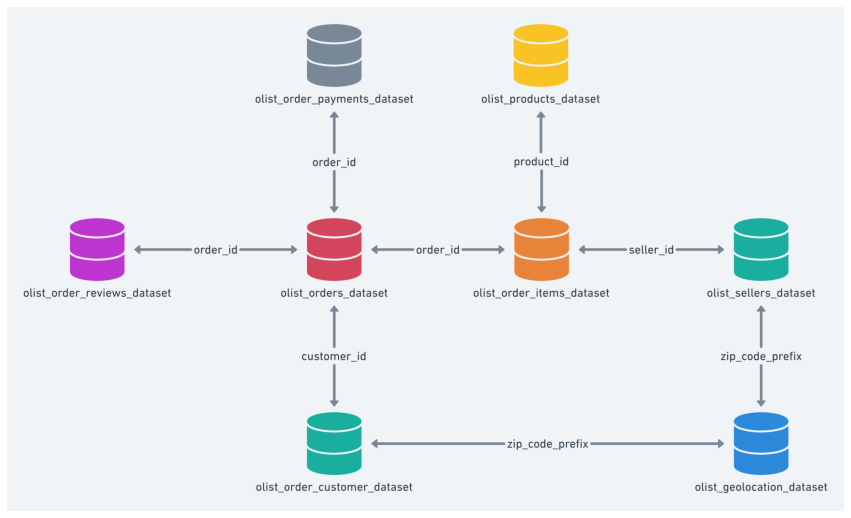

Nb de lignes :
df_customers : 99441
df_geolocation : 19015
df_items : 112650
df_payments : 99440
df_reviews : 99441
df_orders : 99441
df_translation : 71
df_products : 32951
df_sellers : 3095
Nombre de clients uniques : 96096


In [55]:
plt.figure(figsize=(15, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(image_data_schema)
plt.show()

print("Nb de lignes :")
print("df_customers :", len(df_customers))
print("df_geolocation :", len(df_geolocation))
print("df_items :", len(df_items))
print("df_payments :", len(df_payments))
print("df_reviews :", len(df_reviews))
print("df_orders :", len(df_orders))
print("df_translation :", len(df_translation))
print("df_products :", len(df_products))
print("df_sellers :", len(df_sellers))
print("Nombre de clients uniques :",
      len(df_customers['customer_unique_id'].unique()))

# Feature engineering

In [56]:
# df_customers ET df_orders
df_customers_orders = pd.merge(
    df_customers,
    df_orders,
    on='customer_id', how='inner')  # copy=True par défaut

df_customers_orders.drop(columns=['customer_id'], inplace=True)

df_customers_orders

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99436  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99437  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99438  e9f50caf99f032f0bf3c55141f019d99  60115                      
99439  73c2643a0a458b49f58cea58833b192e  92120                      
99440  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99436              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99437        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99438              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99439                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99440                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99436  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99437  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99438  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99439  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99440  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99436 2018-04-11 02:08:36          2018-04-13 20:06:37             
99437 2018-04-05 18:42:35          2018-04-11 18:54:45             
99438 2018-04-09 17:52:17          2018-05-09 19:03:15             
99439 2017-11-06 18:24:41          2017-11-16 19:58:39             
99440 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  
0     2017-06-05                     
1     2018-02-06                     
2     2018-06-13                     
3     2018-04-10                     
4     2018-08-15                     
...                             ...  
99436 2018-04-25                     
99437 2018-04-20                     
99438 2018-05-02                     
99439 2017-12-05                     
99440 2018-01-08                     

[99441 rows x 11 columns]

## Récences (par trimestre, pour chaque client)

Mode opératoire :  
1) filtrer par date (ne garder qu'un trimestre).  
2) pour chaque customer :  
\- trouver le dernier achat.  
\- calculer la récence.  


Note : dans la version finale du notebook, la récence ne fait plus partie des variables retenues pour le clustering.  

In [57]:
df_customers_orders_recence = df_customers_orders.copy()
for i in range(1, 7):
    # filtration par trimestre
    df_trim = filtre_dataframe_par_periode(
        df_customers_orders,
        ['customer_unique_id', 'order_purchase_timestamp'], DATES[i - 1],
        DATES[i])
    # groupby sur customer_unique_id, puis calcul du max() pour chaque groupe
    df_trim_recent = df_trim.groupby('customer_unique_id', sort=False).max()
    # calcul de la récence
    ser_recence = DATES[i] - df_trim_recent['order_purchase_timestamp'].copy()
    ser_recence.name = 'récence_fin_trimestre_' + str(i)
    # Union df_customers_orders ET df_trim_recent
    df_customers_orders_recence = pd.merge(df_customers_orders_recence,
                                           ser_recence,
                                           on='customer_unique_id',
                                           how='left')  # copy=True par défaut

df_customers_orders_recence

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99436  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99437  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99438  e9f50caf99f032f0bf3c55141f019d99  60115                      
99439  73c2643a0a458b49f58cea58833b192e  92120                      
99440  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99436              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99437        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99438              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99439                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99440                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99436  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99437  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99438  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99439  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99440  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99436 2018-04-11 02:08:36          2018-04-13 20:06:37             
99437 2018-04-05 18:42:35          2018-04-11 18:54:45             
99438 2018-04-09 17:52:17          2018-05-09 19:03:15             
99439 2017-11-06 18:24:41          2017-11-16 19:58:39             
99440 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date récence_fin_trimestre_1  \
0     2017-06-05                    8 days 08:54:25           
1     2018-02-06                                NaT           
2     2018-06-13                                NaT           
3     2018-04-10                                NaT           
4     2018-08-15                                NaT           
...                             ...                     ...   
99436 2018-04-25                                NaT           
99437 2018-04-20                                NaT           
99438 2018-05-0

La plupart des clients font un achat unique. La récence est surtout liée à la date choisie pour la fin d'un trimestre.  
Je ne vois pas la pertinence de la récence pour du clustering sur les données Olist. En particulier par rapport à la problématique de stabilité des clusters.    
Je ne vois d'intérêt à utiliser la récence que pour une campagne ciblée sur le trimestre en cours.  

## Fréquences (nb d'ordres par trimestres)

Mode opératoire :  
1) filtrer par date (ne garder qu'un trimestre).  
2) pour chaque customer :  
\- trouver les ordres.  
\- sommer le nb d'ordres.  

In [58]:
for i in range(1, 7):
    # filtration par trimestre
    df_trim = filtre_dataframe_par_periode(
        df_customers_orders,
        ['customer_unique_id', 'order_purchase_timestamp'], DATES[i - 1],
        DATES[i])
    # groupby sur customer_unique_id, puis calcul du count pour chaque groupe
    df_trim_count = df_trim.groupby('customer_unique_id', sort=False).count()
    # renommage de la colonne
    df_trim_count.columns = ['nb_ordres_trimestre_' + str(i)]
    # Union df_customers_orders ET df_trim1_count
    df_customers_orders = pd.merge(df_customers_orders,
                                   df_trim_count,
                                   on='customer_unique_id',
                                   how='left')  # copy=True par défaut

df_customers_orders

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99436  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99437  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99438  e9f50caf99f032f0bf3c55141f019d99  60115                      
99439  73c2643a0a458b49f58cea58833b192e  92120                      
99440  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99436              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99437        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99438              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99439                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99440                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99436  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99437  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99438  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99439  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99440  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99436 2018-04-11 02:08:36          2018-04-13 20:06:37             
99437 2018-04-05 18:42:35          2018-04-11 18:54:45             
99438 2018-04-09 17:52:17          2018-05-09 19:03:15             
99439 2017-11-06 18:24:41          2017-11-16 19:58:39             
99440 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99436 2018-04-25                     NaN                     
99437 2018-04-20                     NaN                     
99438 2018-05-02        

## Montant total (par trimestre)

In [59]:
# df_customers ET df_orders ET df_payments
df_customers_orders_payments = pd.merge(
    df_customers_orders,
    df_payments,
    on='order_id', how='inner')  # copy=True par défaut

df_customers_orders_payments

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

In [60]:
# ajout des colonnes montant_total_trimestre_X
for i in range(1, 7):
    # filtration par trimestre
    df_trim = filtre_dataframe_par_periode(
        df_customers_orders_payments,
        ['customer_unique_id', 'payment_value_order'], DATES[i - 1], DATES[i])
    # groupby sur customer_unique_id, puis calcul du sum() pour chaque groupe
    df_trim_sum = df_trim.groupby('customer_unique_id', sort=False).sum()
    # renommage de la colonne
    df_trim_sum.columns = ['montant_total_trimestre_' + str(i)]
    # Union df_customers_orders_payments ET df_trim_sum
    df_customers_orders_payments = pd.merge(df_customers_orders_payments,
                                            df_trim_sum,
                                            on='customer_unique_id',
                                            how='left')

df_customers_orders_payments

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

In [61]:
# on teste qu'on a bien fait la somme des différents ordres des clients \
# à ordres multiples pour un même trimestre
ser_bool_duplicated = df_customers_orders_payments[
    'customer_unique_id'].duplicated(keep=False)
df_customers_orders_payments[ser_bool_duplicated].sort_values(
    by='customer_unique_id')

customer_unique_id                 customer_zip_code_prefix  \
35607  00172711b30d52eea8b313a7f2cced02  45200                      
19299  00172711b30d52eea8b313a7f2cced02  45200                      
20023  004288347e5e88a27ded2bb23747066c  26220                      
22065  004288347e5e88a27ded2bb23747066c  26220                      
72450  004b45ec5c64187465168251cd1c9c2f  57055                      
...                                 ...                       ...   
75056  ff922bdd6bafcdf99cb90d7f39cea5b3  17340                      
27991  ff922bdd6bafcdf99cb90d7f39cea5b3  17340                      
79858  ff922bdd6bafcdf99cb90d7f39cea5b3  17340                      
64322  ffe254cc039740e17dd15a5305035928  37640                      
12133  ffe254cc039740e17dd15a5305035928  37640                      

      customer_city customer_state order_id                           \
35607        jequie  BA             c306eca42d32507b970739b5b6a5a33a   
19299        jequie  BA             bb874c45df1a3c97842d52f31efee99a   
20023   nova iguacu  RJ             a61d617fbe5bd006e40d3a0988fc844b   
22065   nova iguacu  RJ             08204559bebd39e09ee52dcb56d8faa2   
72450        maceio  AL             90ae229a4addcfead792e2564554f09c   
...             ...            ...                               ...   
75056  barra bonita  SP             fd216c435fda2be27c92920a5e5dba82   
27991  barra bonita  SP             6be1646fccbb69d34b22da3b1807d51d   
79858  barra bonita  SP             5f79e2da24a52e76bc22897df03a7901   
64322       extrema  MG             39a0e2f723def2e12a51e963006c9242   
12133       extrema  MG             ebe76afae9242fc70b0b807b78f17adb   

      order_status order_purchase_timestamp order_approved_at    \
35607   canceled   2018-08-13 09:14:07                      NaT   
19299  delivered   2018-07-28 00:23:49      2018-07-28 00:35:19   
20023  delivered   2017-07-27 14:13:03      2017-07-27 14:25:14   
22065  delivered   2018-01-14 07:36:54      2018-01-14 07:49:28   
72450    shipped   2017-09-01 12:11:23      2017-09-05 04:30:20   
...            ...                      ...                 ...   
75056  delivered   2017-02-22 12:26:42      2017-02-22 13:05:25   
27991  delivered   2017-09-14 14:24:04      2017-09-14 14:39:31   
79858  delivered   2017-08-23 13:15:29      2017-08-23 13:30:19   
64322  delivered   2017-04-02 16:33:30      2017-04-02 16:42:23   
12133  delivered   2017-04-02 16:33:30      2017-04-02 16:42:25   

      order_delivered_carrier_date order_delivered_customer_date  \
35607                 NaT                          NaT             
19299 2018-07-31 15:57:00          2018-08-07 19:28:41             
20023 2017-07-28 17:45:36          2017-08-04 16:26:54             
22065 2018-01-16 16:39:34          2018-01-19 22:14:14             
72450 2017-09-08 19:42:16                          NaT             
...                            ...                           ...   
75056 2017-02-23 13:26:17          2017-03-08 02:02:59             
27991 2017-09-14 20:43:36          2017-09-18 20:47:54             
79858 2017-09-22 13:45:55          2017-09-25 21:34:47             
64322 2017-04-06 10:38:35          2017-04-19 16:13:08             
12133 2017-04-10 10:14:32          2017-04-20 09:33:20             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
35607 2018-09-05                     NaN                     
19299 2018-08-22                     NaN                     
20023 2017-08-18                     NaN                     
22065 2018-02-09                     NaN                     
72450 2017-10-06                     NaN                     
...                             ...                    ...   
75056 2017-03-23                     NaN                     
27991 2017-10-02                     NaN                     
79858 2017-09-21                     NaN                     
64322 2017-04-28                     2.0                     
12133 20

## Montant moyen (par ordre, par trimestre)

In [62]:
for i in range(1, 7):
    df_customers_orders_payments['montant_moyen_trimestre_' + str(i)] = \
        df_customers_orders_payments['montant_total_trimestre_' + str(i)] / \
        df_customers_orders_payments['nb_ordres_trimestre_' + str(i)]

df_customers_orders_payments

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

## Payment installments par ordre (moyenne, par trimestre)

Mode opératoire :  
1) filtrer par date (ne garder qu'un trimestre).  
2) pour chaque customer :  
\- trouver les ordres.  
\- sommer le nb d'installents.  
\- diviser par la fréquence.

### Somme des installments

In [63]:
for i in range(1, 7):
    # filtration par trimestre
    df_trim = filtre_dataframe_par_periode(
        df_customers_orders_payments,
        ['customer_unique_id', 'payment_installments'],
        DATES[i - 1], DATES[i])
    # groupby sur customer_unique_id, puis calcul du sum() pour chaque groupe
    df_trim_sum = df_trim.groupby('customer_unique_id', sort=False).sum()
    # renommage de la colonne
    df_trim_sum.columns = ['installments_somme_trimestre_' + str(i)]
    # Union df_customers_orders_payments ET df_trim_sum
    df_customers_orders_payments = pd.merge(df_customers_orders_payments,
                                            df_trim_sum,
                                            on='customer_unique_id',
                                            how='left')

df_customers_orders_payments

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

### Moyenne des installments

In [64]:
# on divise la colonne 'installments_somme' par la fréquence pour obtenir
# le nb moyen d'installments par ordre
colonnes_effacer = []
for i in range(1, 7):
    df_customers_orders_payments['installments_moyenne_trimestre_' + str(i)] \
        = df_customers_orders_payments['installments_somme_trimestre_' + str(i)] \
        / df_customers_orders_payments['nb_ordres_trimestre_' + str(i)]
    colonnes_effacer.append('installments_somme_trimestre_' + str(i))

# suppression des colonnes installments_somme_trimestre_
df_customers_orders_payments.drop(columns=colonnes_effacer, inplace=True)

df_customers_orders_payments

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

## Review score (moyenne, par trimestre)

In [65]:
# df_reviews est réduit aux seules colonnes nécessaires pour la jointure
df_reviews_reduit = df_reviews[['order_id', 'review_score']]

# df_customers ET df_orders ET df_payments ET reviews
df_customers_orders_payments_reviews = pd.merge(
    df_customers_orders_payments,
    df_reviews_reduit,
    on='order_id', how='inner')  # copy=True par défaut

df_customers_orders_payments_reviews

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

In [66]:
# ajout des review_score_moyenne_trimestre_X
for i in range(1, 7):
    # filtration par trimestre
    df_trim = filtre_dataframe_par_periode(
        df_customers_orders_payments_reviews,
        ['customer_unique_id', 'review_score'], DATES[i - 1], DATES[i])
    # groupby sur customer_unique_id, puis calcul du mean() pour chaque groupe
    df_trim_mean = df_trim.groupby('customer_unique_id', sort=False).mean()
    # renommage de la colonne
    df_trim_mean.columns = ['review_score_moyenne_trimestre_' + str(i)]
    # Union df_customers_orders_payments_reviews ET df_trim_mean
    df_customers_orders_payments_reviews = pd.merge(
        df_customers_orders_payments_reviews,
        df_trim_mean,
        on='customer_unique_id',
        how='left')  # copy=True par défaut

df_customers_orders_payments_reviews

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

In [67]:
# on teste qu'on a bien fait la somme des différents ordres \
# des clients à ordres multiples
ser_bool_duplicated = df_customers_orders_payments_reviews[
    'customer_unique_id'].duplicated(keep=False)
df_customers_orders_payments_reviews[ser_bool_duplicated].sort_values(
    by='customer_unique_id')

customer_unique_id                 customer_zip_code_prefix  \
35607  00172711b30d52eea8b313a7f2cced02  45200                      
19299  00172711b30d52eea8b313a7f2cced02  45200                      
20023  004288347e5e88a27ded2bb23747066c  26220                      
22065  004288347e5e88a27ded2bb23747066c  26220                      
72450  004b45ec5c64187465168251cd1c9c2f  57055                      
...                                 ...                       ...   
75056  ff922bdd6bafcdf99cb90d7f39cea5b3  17340                      
27991  ff922bdd6bafcdf99cb90d7f39cea5b3  17340                      
79858  ff922bdd6bafcdf99cb90d7f39cea5b3  17340                      
64322  ffe254cc039740e17dd15a5305035928  37640                      
12133  ffe254cc039740e17dd15a5305035928  37640                      

      customer_city customer_state order_id                           \
35607        jequie  BA             c306eca42d32507b970739b5b6a5a33a   
19299        jequie  BA             bb874c45df1a3c97842d52f31efee99a   
20023   nova iguacu  RJ             a61d617fbe5bd006e40d3a0988fc844b   
22065   nova iguacu  RJ             08204559bebd39e09ee52dcb56d8faa2   
72450        maceio  AL             90ae229a4addcfead792e2564554f09c   
...             ...            ...                               ...   
75056  barra bonita  SP             fd216c435fda2be27c92920a5e5dba82   
27991  barra bonita  SP             6be1646fccbb69d34b22da3b1807d51d   
79858  barra bonita  SP             5f79e2da24a52e76bc22897df03a7901   
64322       extrema  MG             39a0e2f723def2e12a51e963006c9242   
12133       extrema  MG             ebe76afae9242fc70b0b807b78f17adb   

      order_status order_purchase_timestamp order_approved_at    \
35607   canceled   2018-08-13 09:14:07                      NaT   
19299  delivered   2018-07-28 00:23:49      2018-07-28 00:35:19   
20023  delivered   2017-07-27 14:13:03      2017-07-27 14:25:14   
22065  delivered   2018-01-14 07:36:54      2018-01-14 07:49:28   
72450    shipped   2017-09-01 12:11:23      2017-09-05 04:30:20   
...            ...                      ...                 ...   
75056  delivered   2017-02-22 12:26:42      2017-02-22 13:05:25   
27991  delivered   2017-09-14 14:24:04      2017-09-14 14:39:31   
79858  delivered   2017-08-23 13:15:29      2017-08-23 13:30:19   
64322  delivered   2017-04-02 16:33:30      2017-04-02 16:42:23   
12133  delivered   2017-04-02 16:33:30      2017-04-02 16:42:25   

      order_delivered_carrier_date order_delivered_customer_date  \
35607                 NaT                          NaT             
19299 2018-07-31 15:57:00          2018-08-07 19:28:41             
20023 2017-07-28 17:45:36          2017-08-04 16:26:54             
22065 2018-01-16 16:39:34          2018-01-19 22:14:14             
72450 2017-09-08 19:42:16                          NaT             
...                            ...                           ...   
75056 2017-02-23 13:26:17          2017-03-08 02:02:59             
27991 2017-09-14 20:43:36          2017-09-18 20:47:54             
79858 2017-09-22 13:45:55          2017-09-25 21:34:47             
64322 2017-04-06 10:38:35          2017-04-19 16:13:08             
12133 2017-04-10 10:14:32          2017-04-20 09:33:20             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
35607 2018-09-05                     NaN                     
19299 2018-08-22                     NaN                     
20023 2017-08-18                     NaN                     
22065 2018-02-09                     NaN                     
72450 2017-10-06                     NaN                     
...                             ...                    ...   
75056 2017-03-23                     NaN                     
27991 2017-10-02                     NaN                     
79858 2017-09-21                     NaN                     
64322 2017-04-28                     2.0                     
12133 20

## Durée livraison / livraison réalisée

L'idée initiale est de calculer la durée suivante : order_delivered_customer_date - order_purchase_timestamp.  
Le problème est qu'en procédant ainsi, tous les ordres sans l'order_delivered_customer_date seront éliminés dans l'étape de modélisation, i.e. on ne garderait que des client qui auraient été livrés.  
  
Regarder le statut 'delivered' n'est pas concluant non plus, car en lisant les commentaires on observe des clients satisfaits pour des livraisons qui ne sont pas renseignées.  
  
Bref, les données de livraison ne sont pas fiables, et ne sont pas utilisées.  

In [68]:
df_customers_orders_payments_reviews[
    "duree_livraison"] = \
    df_customers_orders_payments_reviews.order_delivered_customer_date - \
    df_customers_orders_payments_reviews.order_purchase_timestamp
df_customers_orders_payments_reviews.sample(100)

customer_unique_id                 customer_zip_code_prefix  \
8136   9980291d85be337ac289b076d64bfa5d  29145                      
55540  e5a496ca44e566e4ca1208c6692d0d20  41740                      
52531  fd0973921b50c01984ebf2202e21b942   4623                      
79231  570a97232e0dd95c690bc0a5d0ac86b6  72583                      
49365  1e3a18d52c7ff0af7a6f8ff80bafc907  90200                      
14012  c4a6d90ff659b1fc7a16bb0681f2afa7  17520                      
43023  56a5ac6efdc86f167b16c26fe1b4c91f  60326                      
33118  ce08c5d1cb6ac8f714dc79680c3f7a01   9521                      
65727  e2ad8bcf2251723975d35fb6d5588e29   3160                      
32961  e03dbdf5e56c96b106d8115ac336f47f  35502                      
13507  decb307ddea7099666fdaa07689ac885  13178                      
60583  ca1df6733ab15682f6307b55ee280634  38307                      
54696  8fbefa23ae0c37b2b4ca94dd96abdb78  21230                      
71023  2fd07dc5dbae616986e00fb72e7a779b  12327                      
42009  0d21c75cf38638bec391a55dcabdfc05   4707                      
93984  bf07069bc4c6554e5ca938d5692348a9  95200                      
12630  d8c0f846f1bfe502f895e3d1a838300e  49010                      
86379  d5e474bbd54ff9219813f4e65858f099  75043                      
65788  9b1d4ea0e572459ee5e947abf3ca631d  14400                      
19351  288ffe8ed0aea8343566e87875c890b5  29155                      
75588  7af7ebbed73f6c1ca5c0541e33071887  30720                      
59133  aadac29aa0038b157c996d1cebd8cc82  16370                      
31889  512088ab9401e9c88db7e133824cc835  48609                      
77459  e4830071207eb6aa2f738dc965f05f50   4787                      
6319   b388ef1fc20ac12fa9fb8bd448d2f961  39625                      
34303  d7bd53ba01362007c81eecf88132db1e  27524                      
45742  4566d9372163fae40e6c17b2f3d65b96   4112                      
9050   8a800a471470ca3805b189f893a57515  60175                      
50140  3abc34087edcf535bc8f5f337314d6d8  89610                      
97843  ee94c6489208799271238c965bdbd1ac   6784                      
90654  fe1304c4f4698b4763212d7a707161a4   4195                      
75436  c9e3d0ba306a0b9741b499df70fdb976   7020                      
75941  96734f9252c53f142a7a07a96274d12c  22411                      
99315  4c238e06836176bcacf75f445cd4876b  89500                      
67335  af5aa18fac61372515c2e7b4546e28c6  73930                      
38156  1f4cffb6645eae7e8f7be7047470efb4  22250                      
82818  84581bcc9cd2ee220626ca0917b93cc0  31030                      
36530  5d0178b3ae43ec69cf3482b72348b14b  88052                      
88416  6150fedf315a60da35736cb17949a42b  89124                      
5869   ceac2416c11b2dccc354ad4981f38ab2   4517                      
52257  364f7b4c100b3b8793389cbf6a72ea58   5756                      
34054  4fcf56f1cf3d583a0cec41f7f523a852   7080                      
12885  03a7ce913dd0cfe59f041029fdd9f326  11740                      
95521  b6264382015251f0779ccb486bd9cc8e  51020                      
62636  a66ef26cbab754cef9bd1fd7643813a4   6541                      
81122  1eed64a33be0c6e7f682322f9890191e  69050                      
50117  9da935f0be40e2ceb003fe01731fac57  39403                      
940    ab2d1ba701c748469008304cb9f83770   9784                      
71161  f8349adab2270dd8dcaea0aef8f96b35   1422                      
1883   d8e40a4b16990a6fd1095feae46aa1af  13562                      
46468  41c480dc6e903cb421d153b0171385d5   5688                      
77651  bffc4415e44bfe97f6a0267d81c294fe  24436                      
45560  90543c70cb41b87112bb0359ed6d16ac   2423                      
9243   a3d6706e1d475bb73316ab0fa91cbc3a   6474                      
29326  ed14c914fb7b1a6077b79889275f99b3  31110                      
90119  580b560f0f8ae08a6c203ef6c55c9b4f  13473                      
27449  23d7011ee3b2d9f4a392b72077522fcf  78450                      
6347

In [69]:
df_customers_orders_payments_reviews["duree_livraison"].isnull().sum()

2965

## Finalisation du feature engineering (une seule ligne par client)

In [70]:
# Il ne faut garder qu'une seule ligne par customer_unique_id
df_customers_orders_payments_reviews.drop_duplicates(
    subset='customer_unique_id', keep='first', inplace=True)
df_customers_orders_payments_reviews

customer_unique_id                 customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0  14409                      
1      290c77bc529b7ac935b93aa66c333dc3   9790                      
2      060e732b5b29e8181a18229c7b0b2b5e   1151                      
3      259dac757896d24d7702b9acbbff3f3c   8775                      
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
...                                 ...                       ...   
99435  1a29b476fee25c95fbafc67c5ac95cf8   3937                      
99436  d52a67c98be1cf6a5c84435bd38d095d   6764                      
99437  e9f50caf99f032f0bf3c55141f019d99  60115                      
99438  73c2643a0a458b49f58cea58833b192e  92120                      
99439  84732c5050c01db9b23e19ba39899398   6703                      

      customer_city          customer_state order_id                           \
0                     franca  SP             00e7ee1b050b8499577073aeb2a297a1   
1      sao bernardo do campo  SP             29150127e6685892b6eab3eec79f59c7   
2                  sao paulo  SP             b2059ed67ce144a36e2aa97d2c9e9ad2   
3            mogi das cruzes  SP             951670f92359f4fe4a63112aa7306eba   
4                   campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
...                      ...            ...                               ...   
99435              sao paulo  SP             6760e20addcf0121e9d58f2f1ff14298   
99436        taboao da serra  SP             9ec0c8947d973db4f4e8dcf1fbfa8f1b   
99437              fortaleza  CE             fed4434add09a6f332ea398efd656a5c   
99438                 canoas  RS             e31ec91cea1ecf97797787471f98a8c2   
99439                  cotia  SP             28db69209a75e59f20ccbb5c36a20b90   

      order_status order_purchase_timestamp order_approved_at    \
0      delivered   2017-05-16 15:05:35      2017-05-16 15:22:12   
1      delivered   2018-01-12 20:48:24      2018-01-12 20:58:32   
2      delivered   2018-05-19 16:07:45      2018-05-20 16:19:10   
3      delivered   2018-03-13 16:06:38      2018-03-13 17:29:19   
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
...            ...                      ...                 ...   
99435  delivered   2018-04-07 15:48:17      2018-04-07 16:08:45   
99436  delivered   2018-04-04 08:20:22      2018-04-04 08:35:12   
99437  delivered   2018-04-08 20:11:50      2018-04-08 20:30:03   
99438  delivered   2017-11-03 21:08:33      2017-11-03 21:31:20   
99439  delivered   2017-12-19 14:27:23      2017-12-19 18:50:39   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-05-23 10:47:57          2017-05-25 10:35:35             
1     2018-01-15 17:14:59          2018-01-29 12:41:19             
2     2018-06-11 14:31:00          2018-06-14 17:58:51             
3     2018-03-27 23:22:42          2018-03-28 16:04:25             
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
...                            ...                           ...   
99435 2018-04-11 02:08:36          2018-04-13 20:06:37             
99436 2018-04-05 18:42:35          2018-04-11 18:54:45             
99437 2018-04-09 17:52:17          2018-05-09 19:03:15             
99438 2017-11-06 18:24:41          2017-11-16 19:58:39             
99439 2017-12-21 19:17:21          2017-12-26 18:42:36             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
0     2017-06-05                     1.0                     
1     2018-02-06                     NaN                     
2     2018-06-13                     NaN                     
3     2018-04-10                     NaN                     
4     2018-08-15                     NaN                     
...                             ...                    ...   
99435 2018-04-25                     NaN                     
99436 2018-04-20                     NaN                     
99437 2018-05-02        

# Analyse exploratoire

In [71]:
# liste des colonnes
df_customers_orders_payments_reviews.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'nb_ordres_trimestre_1',
       'nb_ordres_trimestre_2', 'nb_ordres_trimestre_3',
       'nb_ordres_trimestre_4', 'nb_ordres_trimestre_5',
       'nb_ordres_trimestre_6', 'payment_installments', 'payment_value_order',
       'montant_total_trimestre_1', 'montant_total_trimestre_2',
       'montant_total_trimestre_3', 'montant_total_trimestre_4',
       'montant_total_trimestre_5', 'montant_total_trimestre_6',
       'montant_moyen_trimestre_1', 'montant_moyen_trimestre_2',
       'montant_moyen_trimestre_3', 'montant_moyen_trimestre_4',
       'montant_moyen_trimestre_5', 'montant_moyen_trimestre_6',
       'installments_moyenne_trimestre_1', 'installments_moyenne_trimestre_2',
       'installmen

In [72]:
# Fonction pour générer une analyse exploratoire avec DataPrep
def generation_analyse_trimestre(df, numero_trimestre):
    """ Prépare le dataframe pour une analyse exploratoire, 
    puis retourne l'analyse exploratoire.
    Args :
    - df : dataframe pandas à explorer
    - numero_trimestre : int ; numéro de trimestre
    Returns : 
    - rapport DataPrep
    """
    i = str(numero_trimestre)
    colonnes = [
        #         'récence_trimestre_' + i,
        'nb_ordres_trimestre_' + i,
        'montant_total_trimestre_' + i,
        'montant_moyen_trimestre_' + i,
        'installments_moyenne_trimestre_' + i,
        'review_score_moyenne_trimestre_' + i
    ]
    df_trim = filtre_dataframe_par_periode(df, colonnes,
                                           DATES[numero_trimestre - 1],
                                           DATES[numero_trimestre])
    return create_report(df_trim)

## Data du trimestre 1

In [73]:
BOOL_EDA = False

In [74]:
report = BOOL_EDA
# report = True
if report:
    report = generation_analyse_trimestre(df_customers_orders_payments_reviews,
                                          1)
report

False

## Data du trimestre 2

In [75]:
report = BOOL_EDA
if report:
    report = generation_analyse_trimestre(df_customers_orders_payments_reviews,
                                          2)
report

False

## Data du trimestre 3

In [76]:
report = BOOL_EDA
if report:
    report = generation_analyse_trimestre(df_customers_orders_payments_reviews,
                                          3)
report

False

## Data du trimestre 4

In [77]:
report = BOOL_EDA
if report:
    report = generation_analyse_trimestre(
        df_customers_orders_payments_reviews, 4)
report

False

## Data du trimestre 5

In [78]:
report = BOOL_EDA
if report:
    report = generation_analyse_trimestre(
        df_customers_orders_payments_reviews, 5)
report

False

## Data du trimestre 6

In [79]:
report = BOOL_EDA
if report:
    report = generation_analyse_trimestre(
        df_customers_orders_payments_reviews, 6)
report

False

### Tracés pour présentation powerpoint

In [80]:
df = filtre_dataframe_par_periode(df_customers_orders_payments_reviews,
                                  df_customers_orders_payments_reviews.columns,
                                  DATES[6-1], DATES[6])
df

customer_unique_id                 customer_zip_code_prefix  \
4      345ecd01c38d18a9036ed96c73b8d066  13056                      
16     5c2991dbd08bbf3cf410713c4de5a0b5  22750                      
17     b6e99561fe6f34a55b0b7da92f8ed775   7124                      
26     9c0096673baf55453a50073f12d1a37f  74310                      
29     a8654e2af5da6bb72f52c22b164855e1   5528                      
...                                 ...                       ...   
99407  fb354969e06f2093c0083cbfbb91864e   1521                      
99408  ff2331f4155cedbbbca83885595b1208   6950                      
99415  e5cf9da72b751849b7b217f7a943d0fa   9060                      
99426  57c2cfb4a80b13ed19b5fb258d29c19d  15720                      
99430  ca186065de6e2d01cfc99763e6d62048  99150                      

      customer_city     customer_state order_id                           \
4              campinas  SP             6b7d50bd145f6fc7f33cebabd7e49d0f   
16       rio de janeiro  RJ             72bab69c50432c6f94d8b50a5f84b69a   
17            guarulhos  SP             ec28553b12bef4b538e5d7454464a1c6   
26              goiania  GO             d10eafa208521dc30796e6a26099b6a6   
29            sao paulo  SP             0330631bdb2ec8c341f487ed9c22fc8b   
...                 ...            ...                               ...   
99407         sao paulo  SP             b2f58affcc178fea2daaf834f1acff5e   
99408         juquitiba  SP             72f3f62e2e4208804e2c4ed8a28ead52   
99415       santo andre  SP             98484b32a3bbf287f3347e001275ed21   
99426  palmeira d'oeste  SP             60c9450e414b5c1a71cf9034cd62ae29   
99430             marau  RS             75c3993b743335fa57b1645f056b59d2   

      order_status order_purchase_timestamp order_approved_at    \
4      delivered   2018-07-29 09:51:30      2018-07-29 10:10:09   
16     delivered   2018-08-13 23:45:05      2018-08-13 23:55:13   
17     delivered   2018-06-18 13:34:21      2018-06-18 13:55:47   
26     delivered   2018-07-14 10:53:11      2018-07-14 11:05:18   
29     delivered   2018-05-25 12:02:08      2018-05-26 02:31:54   
...            ...                      ...                 ...   
99407  delivered   2018-07-14 14:08:11      2018-07-17 04:31:33   
99408  delivered   2018-07-19 08:50:45      2018-07-20 05:05:16   
99415  delivered   2018-07-21 08:04:54      2018-07-21 08:24:16   
99426  delivered   2018-06-29 21:32:12      2018-06-29 21:50:36   
99430  delivered   2018-06-05 13:33:19      2018-06-06 02:55:19   

      order_delivered_carrier_date order_delivered_customer_date  \
4     2018-07-30 15:16:00          2018-08-09 20:55:48             
16    2018-08-15 12:11:00          2018-08-17 20:03:08             
17    2018-06-19 15:07:00          2018-06-21 20:15:28             
26    2018-07-17 17:32:00          2018-07-25 16:28:33             
29    2018-05-29 15:41:00          2018-06-07 22:42:02             
...                            ...                           ...   
99407 2018-07-25 11:18:00          2018-07-26 19:18:32             
99408 2018-07-20 11:01:00          2018-07-25 20:29:45             
99415 2018-07-23 11:58:00          2018-07-24 17:17:30             
99426 2018-07-02 14:24:00          2018-07-06 14:27:49             
99430 2018-06-07 12:39:00          2018-06-13 16:56:28             

      order_estimated_delivery_date  nb_ordres_trimestre_1  \
4     2018-08-15                    NaN                      
16    2018-08-30                    NaN                      
17    2018-07-03                    NaN                      
26    2018-08-08                    NaN                      
29    2018-06-26                    NaN                      
...                             ...                    ...   
99407 2018-07-30                    NaN                      
99408 2018-08-02                    NaN                      
99415 2018-07-31                    NaN                      
99426 2018-07-24      

#### nb ordres

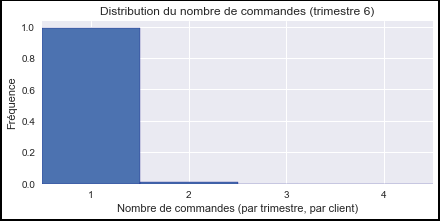

In [81]:
ser = df['nb_ordres_trimestre_6']
ser_max = int(ser.max())

# Histogramme
plt.figure(figsize=(7, 3), edgecolor='black', linewidth=4)
plt.hist(ser, bins=ser_max, density=True, range=(
    0.5, ser_max+0.5), edgecolor='navy')
plt.xticks(ticks=[i+1 for i in range(ser_max)])
plt.xlim((0.5, ser_max+0.5))
plt.xlabel('Nombre de commandes (par trimestre, par client)')
plt.ylabel('Fréquence')
plt.title(f'Distribution du nombre de commandes (trimestre 6)')
plt.show()

#### installments

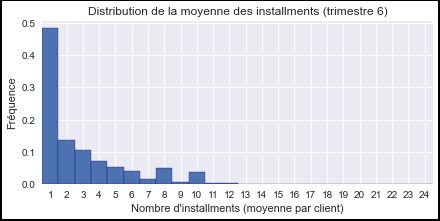

In [82]:
ser = df['installments_moyenne_trimestre_6']
ser_max = int(ser.max())

# Histogramme
plt.figure(figsize=(7, 3), edgecolor='black', linewidth=4)
plt.hist(ser, bins=ser_max, density=True, range=(
    0.5, ser_max+0.5), edgecolor='navy')
plt.xticks(ticks=[i+1 for i in range(ser_max)])
plt.xlim((0.5, ser_max+0.5))
plt.xlabel('Nombre d\'installments (moyenne par client)')
plt.ylabel('Fréquence')
plt.title(f'Distribution de la moyenne des installments (trimestre 6)')
plt.show()

#### montant total

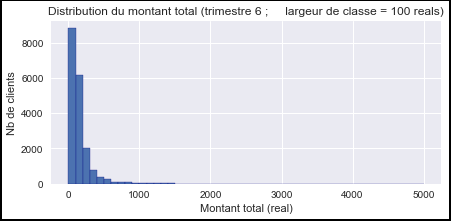

In [83]:
ser = df['montant_total_trimestre_6']
ser_max = int(ser.max())

# Histogramme
plt.figure(figsize=(7, 3), edgecolor='black', linewidth=4)
plt.hist(ser, bins=50, density=False, range=(0, 5000), edgecolor='navy')
# plt.xticks(ticks=[i+1 for i in range(ser_max)])
# plt.xlim((0.5,ser_max+0.5))
plt.xlabel('Montant total (real)')
plt.ylabel('Nb de clients')
plt.title(
    f'Distribution du montant total (trimestre 6 ; \
    largeur de classe = 100 reals)')
plt.show()

#### montant moyen

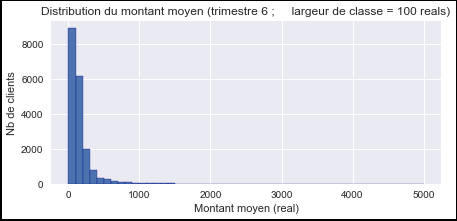

In [84]:
ser = df['montant_moyen_trimestre_6']
ser_max = int(ser.max())

# Histogramme
plt.figure(figsize=(7, 3), edgecolor='black', linewidth=4)
plt.hist(ser, bins=50, density=False, range=(0, 5000), edgecolor='navy')
# plt.xticks(ticks=[i+1 for i in range(ser_max)])
# plt.xlim((0.5,ser_max+0.5))
plt.xlabel('Montant moyen (real)')
plt.ylabel('Nb de clients')
plt.title(
    f'Distribution du montant moyen (trimestre 6 ; \
    largeur de classe = 100 reals)')
plt.show()

#### review score

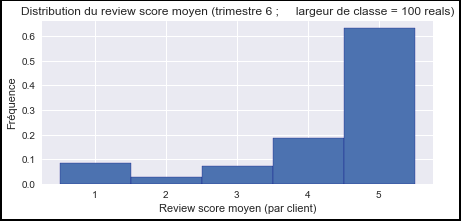

In [85]:
ser = df['review_score_moyenne_trimestre_6']
ser_max = int(ser.max())

# Histogramme
plt.figure(figsize=(7, 3), edgecolor='black', linewidth=4)
plt.hist(ser, bins=5, density=True, range=(0.51, 5.51), edgecolor='navy')
# plt.xticks(ticks=[i+1 for i in range(ser_max)])
# plt.xlim((0.5,ser_max+0.5))
plt.xlabel('Review score moyen (par client)')
plt.ylabel('Fréquence')
plt.title(
    f'Distribution du review score moyen (trimestre 6 ; \
    largeur de classe = 100 reals)')
plt.show()

## Résultats de l'analyse exploratoire

### Analyse monovariée

Pour les variables suivantes : 'récence_fin_trimestre_X', 'nb_ordres_trimestre_X', 'montant_total_trimestre_X', 'montant_moyen_trimestre_X', 'installments_moyenne_trimestre_X', 'review_score_moyenne_trimestre_X', on observe que :  
\- il ne manque pas de données.  
\- il n'y a pas de données aberrantes.  

Distributions des variables :  
\- nb_ordres_trimestre_X : quasiment monomodal. >98% des customers qui passent un order un trimestre ne passent qu'un seul order. Entre 1.1 et 2.1% des customers qui passent un order un trimestre passent deux orders. Rares cas de customers qui passent > 2 orders.   
\- récence_fin_trimestre_X : uniforme (puisque >98% des customers sont mono-order).  

### Analyse bivariée

- très forte corrélation linéaire (r=0.97 à 99 selon trimestre, Pearson) entre les variables montant_total_trimestre_X et montant_moyen_trimestre_X (car elle sont égales pour la plupart des customers, puisque >98% des customers ne passent qu'une seule commande par trimestre).  
- corrélation linéaire faible (r=0.3, Pearson) entre le nb moyen d'installments (installments_moyenne_trimestre_X) et le montant moyen commandé par trimestre (montant_moyen_trimestre_X et montant_total_trimestre_X).  
- absence de corrélation linéaire entre les autres paires de variables.  

# Préparation des dataframes pour l'apprentissage supervisé

###### Fonction prep_data_trim_X()

In [86]:
def prep_data_trim_X(df, trim_X):
    """ Convertit les données issues du feature engineering en données 
    prêtes à l'emploi pour l'apprentissage supervisé.
    Args :
    - df : dataframe pandas à convertir.
    - trim_X (int) : numéro de trimestre.
    Returns : 
    - data_trim_X : dataframe pandas converti.
    - data_scaled_trim_X : dataframe pandas converti, centré et normalisé.
    """
    # selection des colonnes à prendre en compte
    i = str(trim_X)
    colonnes = [
        #         'récence_fin_trimestre_' + i,
        'nb_ordres_trimestre_' + i,
        'montant_total_trimestre_' + i,
        'montant_moyen_trimestre_' + i,
        'installments_moyenne_trimestre_' + i,
        'review_score_moyenne_trimestre_' + i
    ]
    data_trim_X = filtre_dataframe_par_periode(
        df, colonnes, DATES[trim_X - 1],
        DATES[trim_X])

    # on renomme les colonnes (suppression du numéro de trimestre)
    data_trim_X.columns = [
        #         'récence',
        'nb_ordres', 'montant_total', 'montant_moyen',
        'installments', 'review_score'
    ]

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(data_trim_X)
    data_scaled_trim_X = std_scale.transform(data_trim_X)

    return data_trim_X, data_scaled_trim_X

###### Trimestre 1

In [87]:
data_trim_1, data_scaled_trim_1 = prep_data_trim_X(
    df_customers_orders_payments_reviews, 1)
data_trim_1

nb_ordres  montant_total  montant_moyen  installments  review_score
0      1.0        146.87         146.87         2.0           4.0         
18     1.0        102.03         102.03         2.0           3.0         
23     1.0         94.63          94.63         1.0           5.0         
27     1.0         47.59          47.59         1.0           3.0         
63     1.0        146.21         146.21         1.0           4.0         
...          ...            ...            ...           ...           ...
99418  1.0         58.95          58.95         1.0           4.0         
99423  1.0        102.03         102.03         1.0           1.0         
99427  1.0        130.85         130.85         1.0           4.0         
99429  1.0        102.03         102.03         1.0           5.0         
99432  1.0         84.32          84.32         2.0           3.0         

[7894 rows x 5 columns]

In [88]:
data_scaled_trim_1

array([[-0.13707454, -0.08651229, -0.07811847, -0.42292789, -0.04200376],
       [-0.13707454, -0.25206075, -0.25122176, -0.42292789, -0.7860076 ],
       [-0.13707454, -0.27938141, -0.2797892 , -0.76626911,  0.70200007],
       ...,
       [-0.13707454, -0.14565784, -0.13996313, -0.76626911, -0.04200376],
       [-0.13707454, -0.25206075, -0.25122176, -0.76626911,  0.70200007],
       [-0.13707454, -0.31744574, -0.3195906 , -0.42292789, -0.7860076 ]])

###### Trimestre 2

In [89]:
data_trim_2, data_scaled_trim_2 = prep_data_trim_X(
    df_customers_orders_payments_reviews, 2)
data_trim_2

nb_ordres  montant_total  montant_moyen  installments  review_score
20     1.0        123.00         123.00          1.0          5.0         
33     2.0        437.78         218.89          8.0          5.0         
37     1.0         60.00          60.00          2.0          5.0         
54     1.0        809.70         809.70          2.0          1.0         
57     1.0        232.22         232.22          5.0          5.0         
...          ...            ...            ...           ...           ...
99375  1.0         77.57          77.57          1.0          5.0         
99383  1.0        115.30         115.30         10.0          3.0         
99391  1.0         64.00          64.00          1.0          4.0         
99397  1.0        144.66         144.66          3.0          5.0         
99399  1.0        219.63         219.63          4.0          5.0         

[10936 rows x 5 columns]

###### Trimestre 3

In [90]:
data_trim_3, data_scaled_trim_3 = prep_data_trim_X(
    df_customers_orders_payments_reviews, 3)
data_trim_3

nb_ordres  montant_total  montant_moyen  installments  review_score
5      2.0        565.88         282.94         1.0           5.0         
7      1.0         36.01          36.01         3.0           3.0         
12     1.0        117.31         117.31         1.0           4.0         
19     1.0         54.62          54.62         5.0           4.0         
21     1.0        232.71         232.71         2.0           1.0         
...          ...            ...            ...           ...           ...
99404  1.0        121.36         121.36         1.0           5.0         
99413  1.0        217.64         217.64         4.0           5.0         
99422  1.0         32.77          32.77         1.0           5.0         
99428  1.0        199.92         199.92         6.0           1.0         
99438  1.0        711.07         711.07         2.0           5.0         

[14560 rows x 5 columns]

###### Trimestre 4

In [91]:
data_trim_4, data_scaled_trim_4 = prep_data_trim_X(
    df_customers_orders_payments_reviews, 4)
data_trim_4

nb_ordres  montant_total  montant_moyen  installments  review_score
1      1.0        335.48         335.480        8.0           5.0         
6      1.0         22.77          22.770        1.0           5.0         
8      2.0         83.19          41.595        1.0           5.0         
9      1.0        122.47         122.470        1.0           5.0         
10     1.0         40.40          40.400        1.0           5.0         
...          ...            ...            ...           ...           ...
99417  1.0         88.00          88.000        9.0           5.0         
99424  1.0         80.56          80.560        1.0           1.0         
99425  1.0         32.38          32.380        3.0           4.0         
99434  1.0         75.88          75.880        1.0           1.0         
99439  1.0         21.77          21.770        1.0           5.0         

[20084 rows x 5 columns]

In [92]:
data_scaled_trim_4

array([[-0.13054082,  0.99161528,  1.02715858,  1.92154326,  0.73488486],
       [-0.13054082, -0.71254448, -0.71080801, -0.68233347,  0.73488486],
       [ 6.49012029, -0.38327668, -0.60618321, -0.68233347,  0.73488486],
       ...,
       [-0.13054082, -0.66017335, -0.65739796,  0.06163131,  0.03646799],
       [-0.13054082, -0.42311362, -0.41563547, -0.68233347, -2.05878263],
       [-0.13054082, -0.71799413, -0.71636577, -0.68233347,  0.73488486]])

###### Trimestre 5

In [93]:
data_trim_5, data_scaled_trim_5 = prep_data_trim_X(
    df_customers_orders_payments_reviews, 5)
data_trim_5

nb_ordres  montant_total  montant_moyen  installments  review_score
2      1.0        157.73         157.73          7.0          5.0         
3      1.0        173.30         173.30          1.0          5.0         
13     1.0         36.39          36.39          3.0          3.0         
14     1.0        102.47         102.47         10.0          5.0         
22     1.0        163.13         163.13          1.0          4.0         
...          ...            ...            ...           ...           ...
99431  1.0        108.59         108.59          3.0          5.0         
99433  1.0        132.64         132.64          1.0          4.0         
99435  1.0         88.78          88.78          6.0          4.0         
99436  1.0        129.06         129.06          3.0          5.0         
99437  1.0         56.04          56.04          5.0          1.0         

[20684 rows x 5 columns]

###### Trimestre 6

In [94]:
data_trim_6, data_scaled_trim_6 = prep_data_trim_X(
    df_customers_orders_payments_reviews, 6)
data_trim_6

nb_ordres  montant_total  montant_moyen  installments  review_score
4      1.0        252.25         252.25         8.0           5.0         
16     1.0        136.93         136.93         2.0           5.0         
17     1.0         16.53          16.53         1.0           5.0         
26     1.0         62.39          62.39         1.0           5.0         
29     1.0         58.69          58.69         1.0           5.0         
...          ...            ...            ...           ...           ...
99407  1.0        121.04         121.04         1.0           3.0         
99408  1.0        110.88         110.88         1.0           5.0         
99415  1.0        107.96         107.96         2.0           4.0         
99426  1.0         63.00          63.00         6.0           5.0         
99430  1.0         63.73          63.73         1.0           5.0         

[19058 rows x 5 columns]

###### "Tableaux" de données

In [95]:
data_trim = [0, data_trim_1, data_trim_2, data_trim_3,
             data_trim_4, data_trim_5, data_trim_6]
# concaténation des lignes des 6 trimestres
data_trim[0] = pd.concat(data_trim[1:])

data_scaled_trim = [0, data_scaled_trim_1, data_scaled_trim_2,
                    data_scaled_trim_3, data_scaled_trim_4,
                    data_scaled_trim_5, data_scaled_trim_6]
data_scaled_trim[0] = np.concatenate(data_scaled_trim[1:])

# Réduction de dimension et visualisation

###### Fonction affichage_cercles_correlations()

In [96]:
def affichage_cercles_correlations(pca, features):
    """ Affiche les cercles des corrélations de différents plans factoriels
    Args : 
    - pca : sklearn.decomposition.PCA()
    Returns :
    - tracés matplotlib
    """
    # Cercle des corrélations : premier plan factoriel
    display_circles(pca, [(0, 1)], labels=np.array(features))
    # Cercle des corrélations : second plan factoriel
    display_circles(pca, [(2, 3)], labels=np.array(features))
    # Cercle des corrélations : troisième plan factoriel
    display_circles(pca, [(4, 5)], labels=np.array(features))
    # Cercle des corrélations : plan (F1, F3)
    display_circles(pca, [(0, 2)], labels=np.array(features))
    # Cercle des corrélations : plan (F1, F4)
    display_circles(pca, [(0, 3)], labels=np.array(features))
    # Cercle des corrélations : plan (F1, F5)
    display_circles(pca, [(0, 4)], labels=np.array(features))

###### Fonction affichage_clients()

In [97]:
def affichage_clients(pca, data_scaled_trim_X, 
                      illustrative_var=None, axis_ranks=[(0, 2)]):
    """ Affichage des clients sur les plans factoriels
    Args : 
    - pca : sklearn.decomposition.PCA()
    - data_scaled_trim_X : dataframe pandas converti, centré et normalisé.
    - axis_ranks : liste des plans factoriel à tracer. 
    Exemple :  [(0,1), (2,3)] pour tracer les deux premiers plans.
    - illustrative_var : variable catégorielle (série pandas avec même nombre
    d'objets que data_scaled_trim_X).
    Returns :
    - tracés matplotlib
    """
    data_projected = pca.transform(data_scaled_trim_X)
    display_factorial_planes(data_projected, pca, [
                             (0, 1), (0, 2), (0, 3), (0, 4)], size=0.5)
    # label de la projection avec les 'review_score'
    if illustrative_var is not None:
        display_factorial_planes(
            data_projected, pca, illustrative_var=illustrative_var, 
            axis_ranks=axis_ranks, size=5)

## Trimestre 1

### PCA

#### Calcul des composantes principales

In [98]:
features = data_trim_1.columns
pca = decomposition.PCA(n_components=len(features))
pca.fit(data_scaled_trim_1)

PCA(n_components=5)

#### Eboulis des valeurs propres

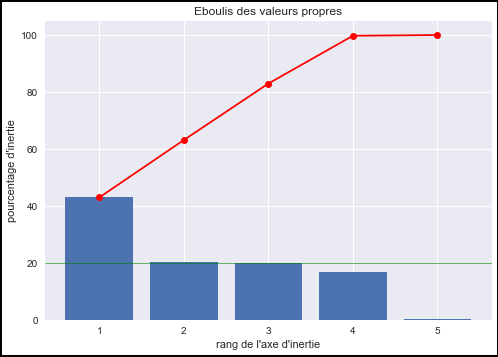

In [99]:
display_scree_plot(pca)

Analyse de l'éboulis :  
\- sur les 5 axes d'inertie, 3 ont une inertie similaire, le premier a une inertie double, le dernier a une inertie quasi nulle.  
\- ça s'interprète par le fait que deux variables (montant total et montant moyen) sont très fortement corrélées entre elles, et qu'hormis ces variables, les variables ne corrèlent pas entre elles.

#### Cercles des corrélations

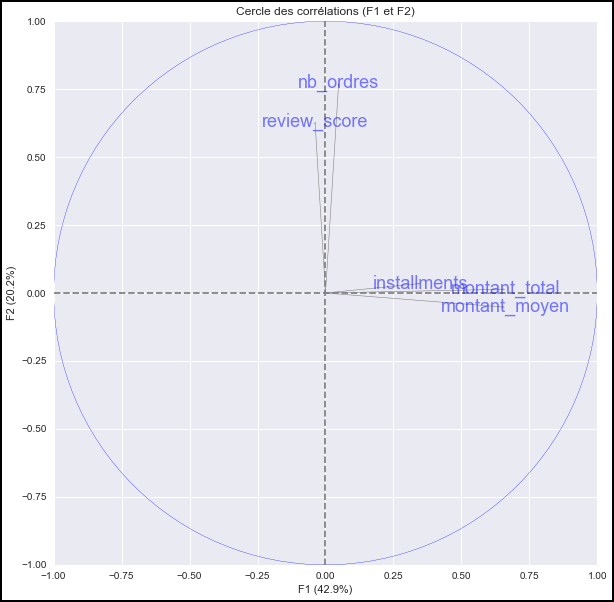

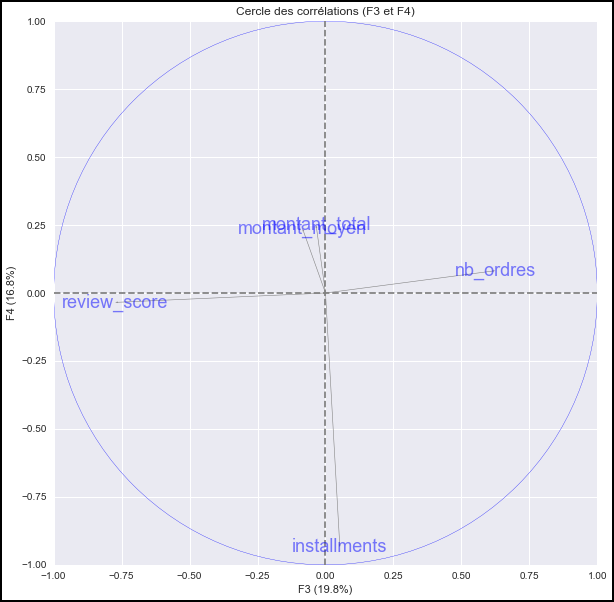

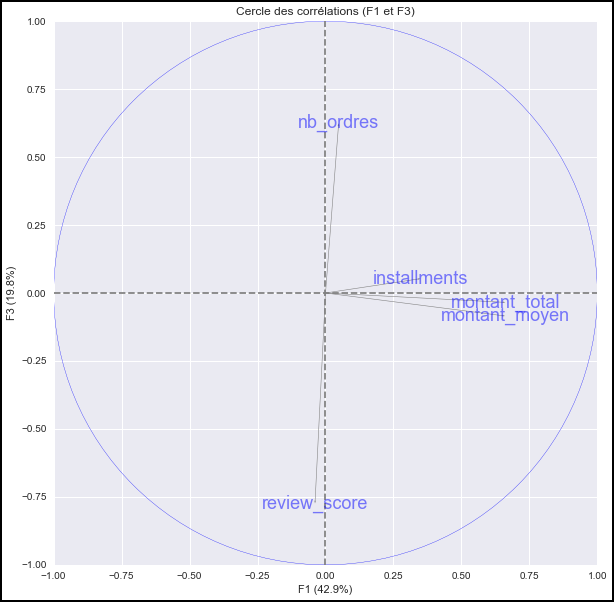

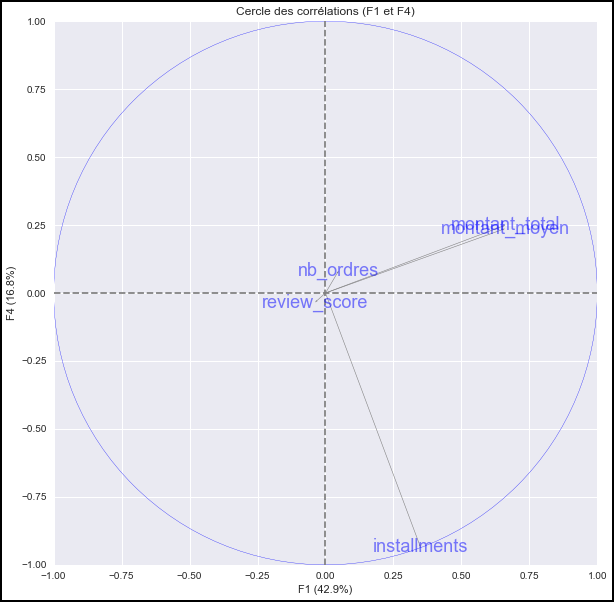

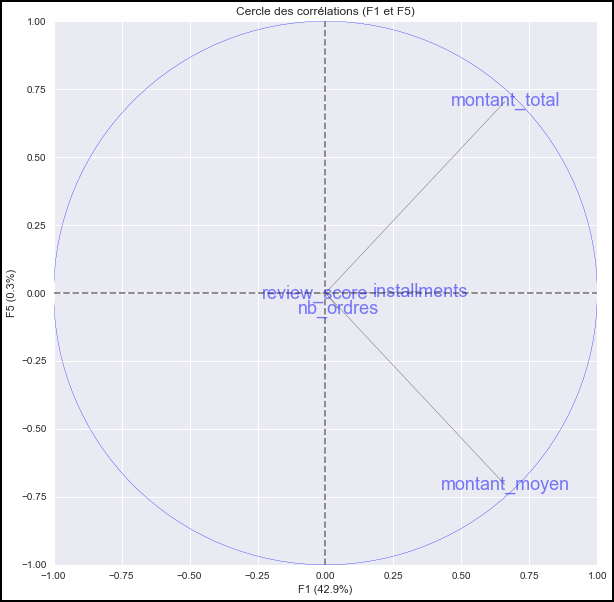

In [100]:
affichage_cercles_correlations(pca, features)

En résumé, les variables sont principalement projetées selon les axes :  
\- montant moyen : F1.   
\- montant total : F1.  
\- nb_ordres : F2.  
\- review_score : -F3.  
\- installments : -F4.  

#### Affichage des clients sur les plans factoriels

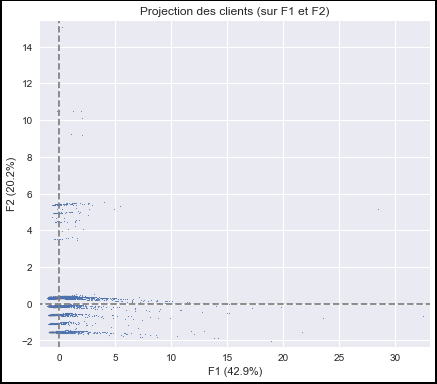

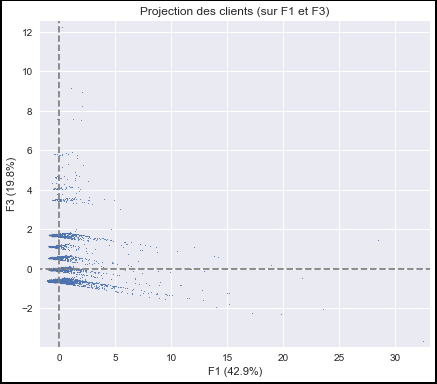

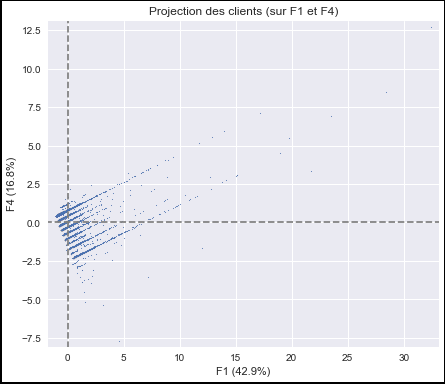

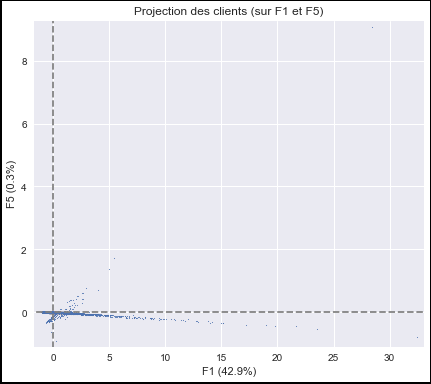

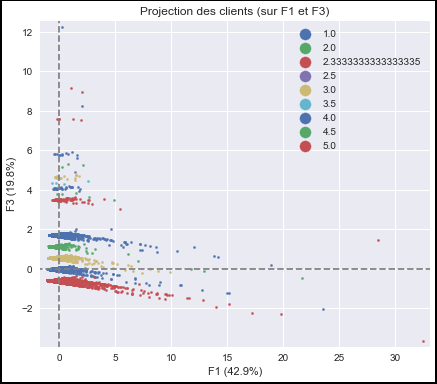

In [101]:
affichage_clients(pca, data_scaled_trim_1,
                  illustrative_var=data_trim_1['review_score'])

Plan factoriel (F1, F3) : on observe 5 clusters (pour les 5 principales notes (1, 2, 3, 4, 5) du review score).

##### Clients segmentés par k-means (k=6)

In [102]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=0)
y_pred = kmeans.fit_predict(data_scaled_trim_1)

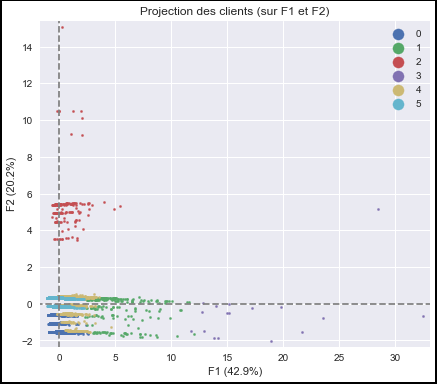

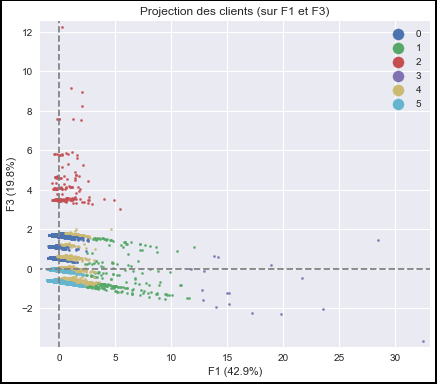

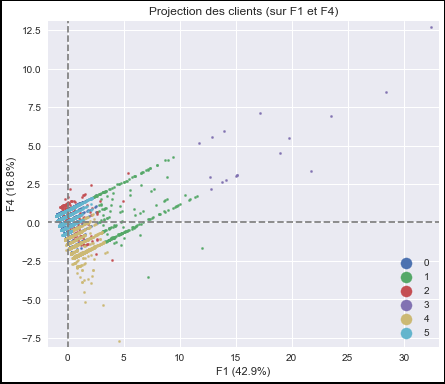

In [103]:
data_projected = pca.transform(data_scaled_trim_1)
display_factorial_planes(
    data_projected, pca, illustrative_var=y_pred, axis_ranks=[(0, 1)])
display_factorial_planes(
    data_projected, pca, illustrative_var=y_pred, axis_ranks=[(0, 2)])
display_factorial_planes(
    data_projected, pca, illustrative_var=y_pred, axis_ranks=[(0, 3)])

### t-SNE

#### Variation de la perplexité

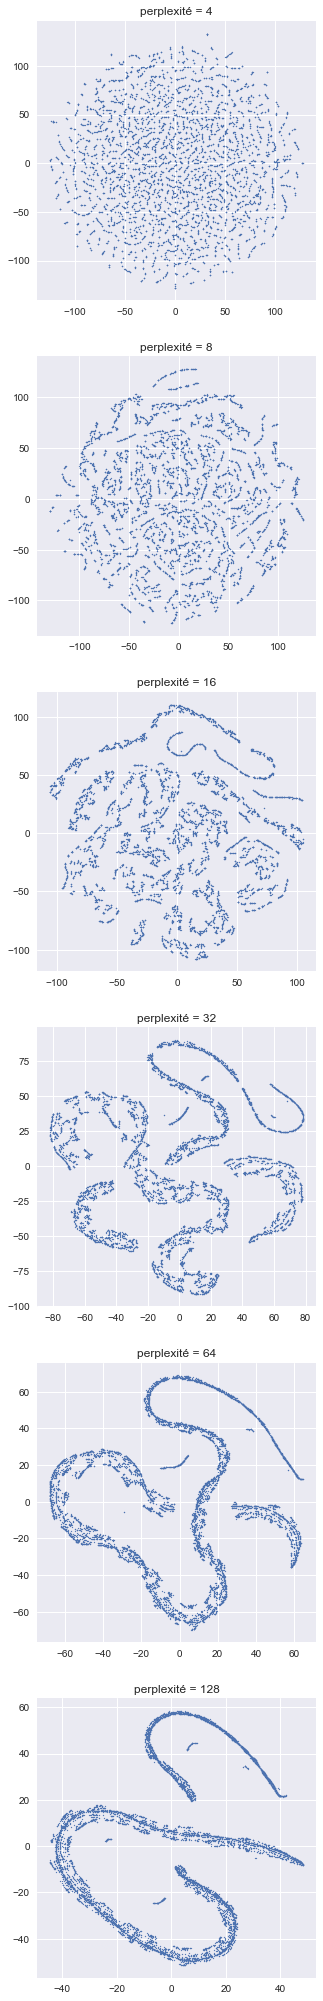

In [185]:
perplexities = [4, 8, 16, 32, 64, 128]
subplots = [611, 612, 613, 614, 615, 616]
plt.figure(figsize=(5, 6*len(perplexities)))

for subplot, perplexity in zip(subplots, perplexities):
    plt.subplot(subplot)
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    data_reduced_tsne = tsne.fit_transform(data_trim_1)
    plt.scatter(data_reduced_tsne[:, 0], data_reduced_tsne[:, 1], s=1)
    plt.title('perplexité = ' + str(perplexity), fontsize=12)
plt.show

#### Labelling du graphe t-SNE après segmentation par k-means (k=6)

In [186]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
y_pred = kmeans.fit_predict(data_scaled_trim_1)

In [187]:
tsne = TSNE(n_components=2, random_state=0, perplexity=32)
data_reduced_tsne = tsne.fit_transform(data_trim_1)

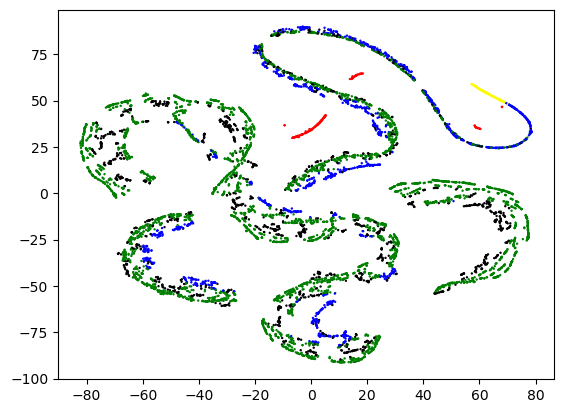

In [188]:
# on plotte la segmentation trouvée par le k-means sur le t-SNE
plt.style.use('default')
plt.scatter(data_reduced_tsne[:, 0],
            data_reduced_tsne[:, 1], s=0.5, c=y_pred, cmap=CMAP5)

#### Labelling du graphe t-SNE après segmentation par k-means (k=6)

In [189]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=0)
y_pred = kmeans.fit_predict(data_scaled_trim_1)

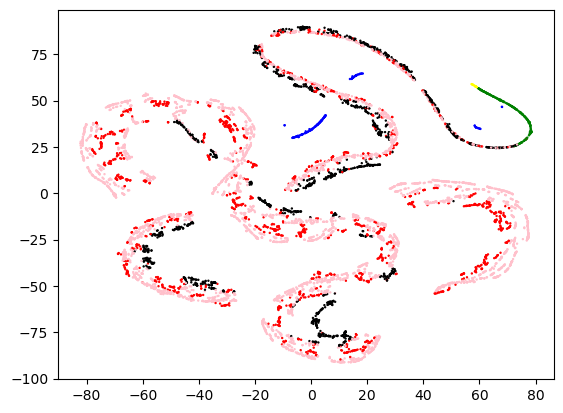

In [190]:
# on plotte la segmentation trouvée par le k-means sur le t-SNE
plt.style.use('default')
# colors = ["red", "green", "blue", "yellow", "black"]
# cmap5 = LinearSegmentedColormap.from_list("mycmap", colors)
plt.scatter(data_reduced_tsne[:, 0],
            data_reduced_tsne[:, 1], s=0.5, c=y_pred, cmap=CMAP6)

## Trimestre 2

### PCA

#### Calcul des composantes principales

In [104]:
features = data_trim_2.columns
pca = decomposition.PCA(n_components=len(features))
pca.fit(data_scaled_trim_2)

PCA(n_components=5)

#### Eboulis des valeurs propres

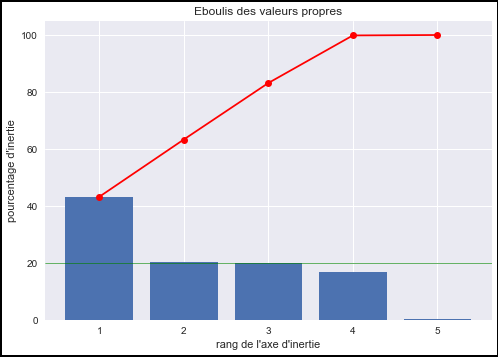

In [105]:
display_scree_plot(pca)

#### Cercles des corrélations

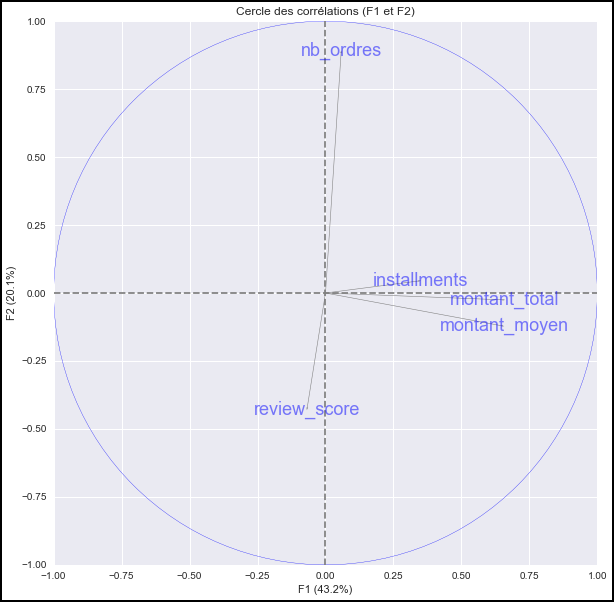

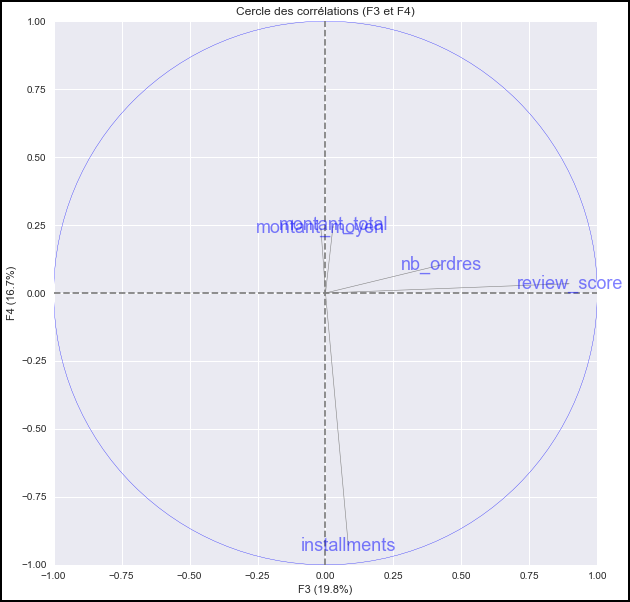

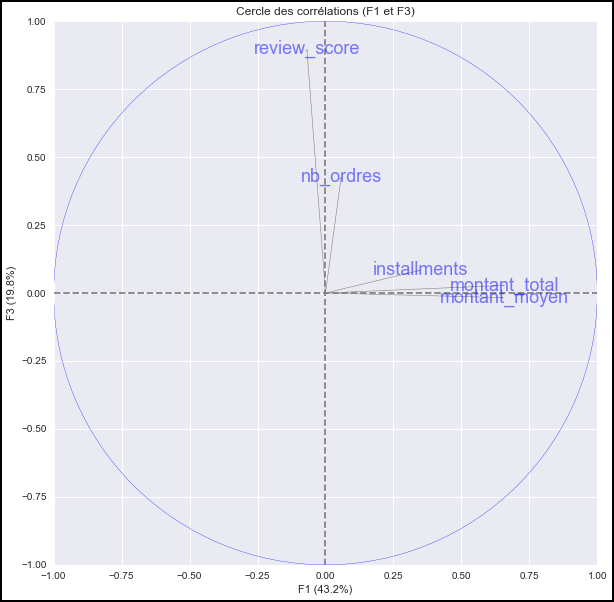

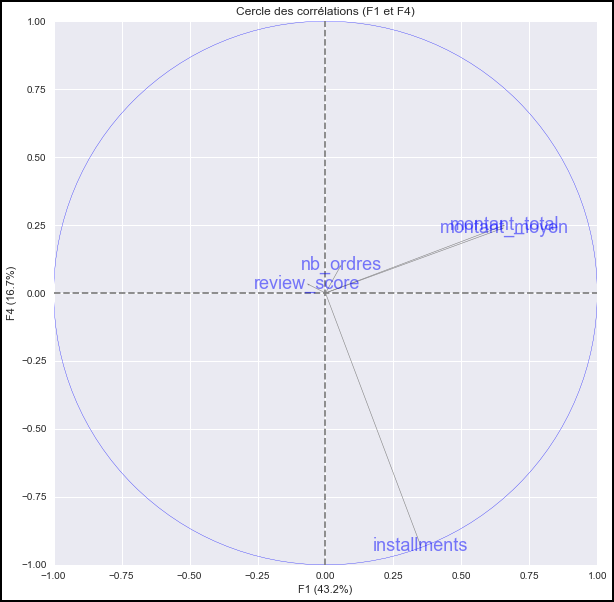

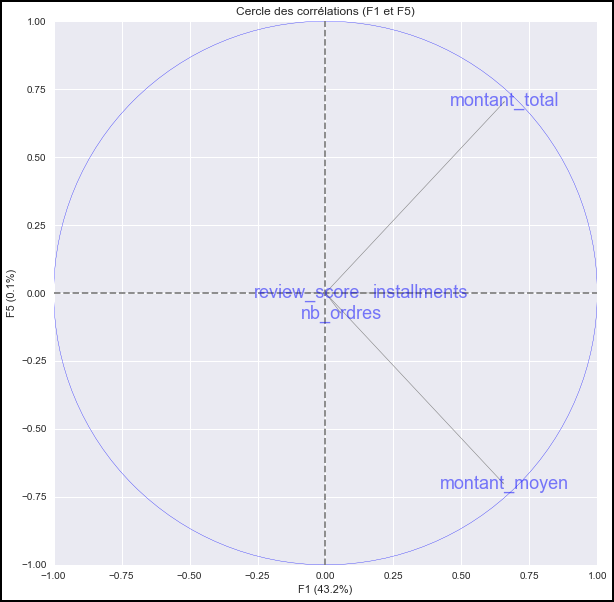

In [106]:
affichage_cercles_correlations(pca, features)

En résumé, les variables sont principalement projetées selon les axes :  
\- montant moyen : F1.   
\- montant total : F1.  
\- nb_ordres : F2.  
\- review_score : F3.  
\- installments : -F4.  

#### Affichage des clients sur les plans factoriels

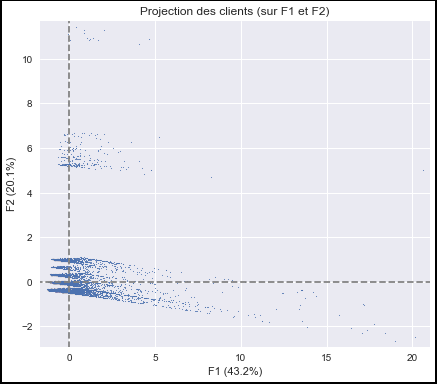

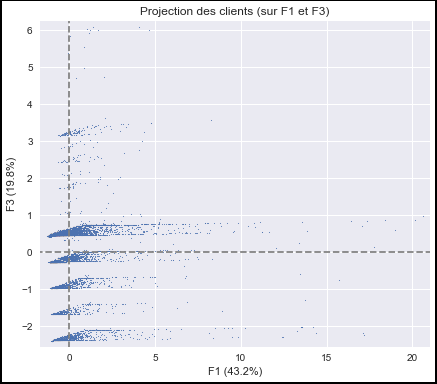

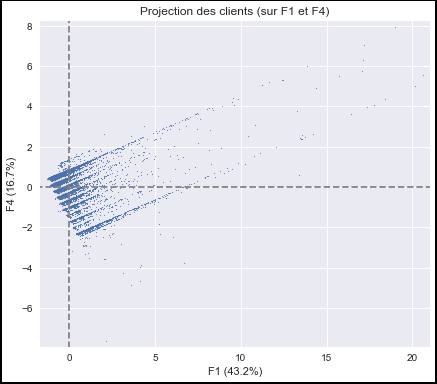

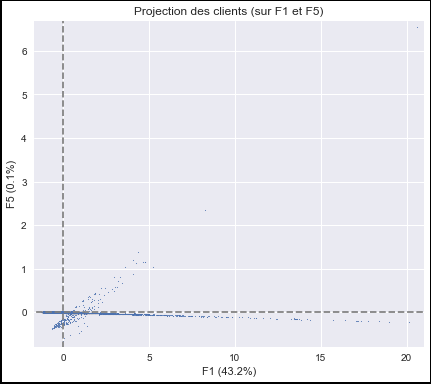

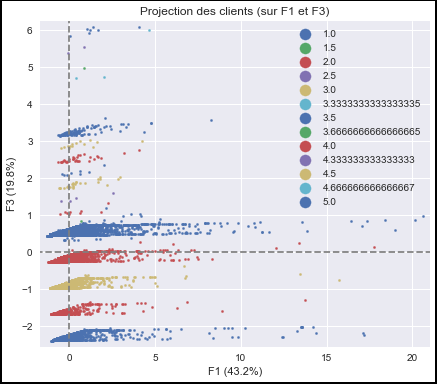

In [107]:
affichage_clients(pca, data_scaled_trim_2,
                  illustrative_var=data_trim_2['review_score'])

Plan factoriel (F1, F3) : on observe 5 clusters (pour les 5 principales notes (1, 2, 3, 4, 5) du review score).

## Trimestre 3

### PCA

#### Calcul des composantes principales

In [108]:
features = data_trim_3.columns
pca = decomposition.PCA(n_components=len(features))
pca.fit(data_scaled_trim_3)

PCA(n_components=5)

#### Eboulis des valeurs propres

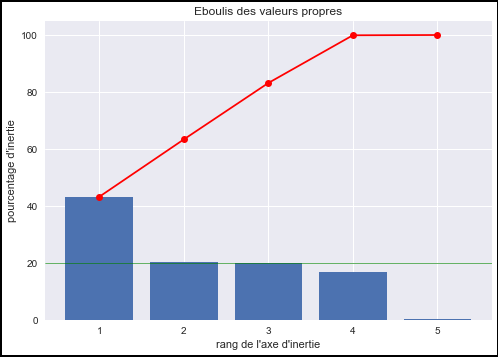

In [109]:
display_scree_plot(pca)

#### Cercles des corrélations

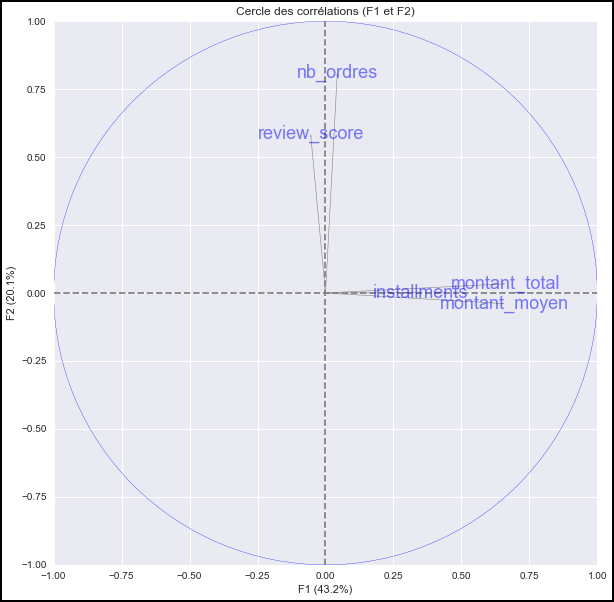

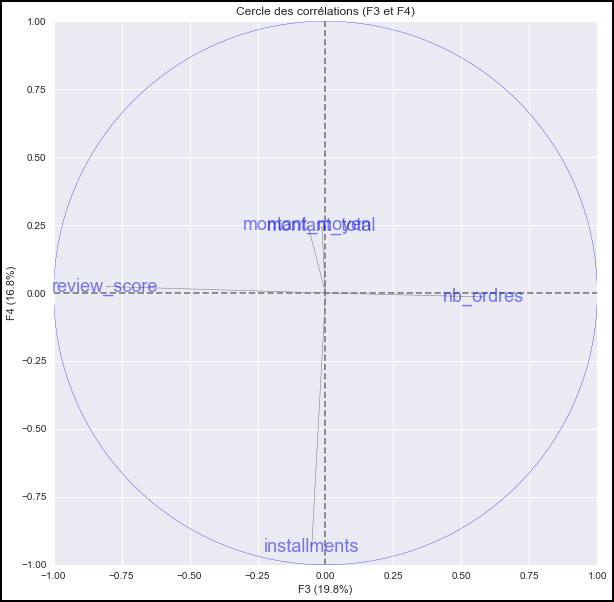

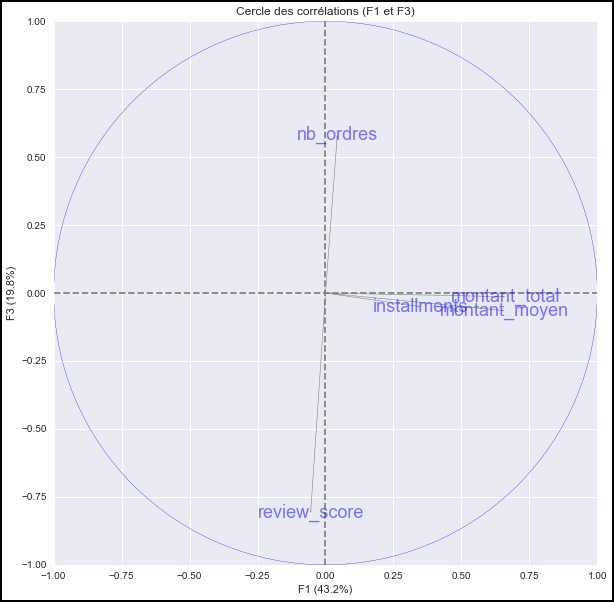

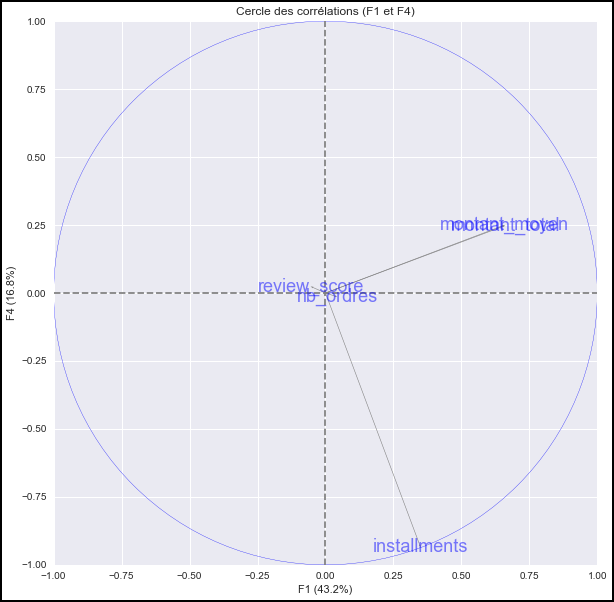

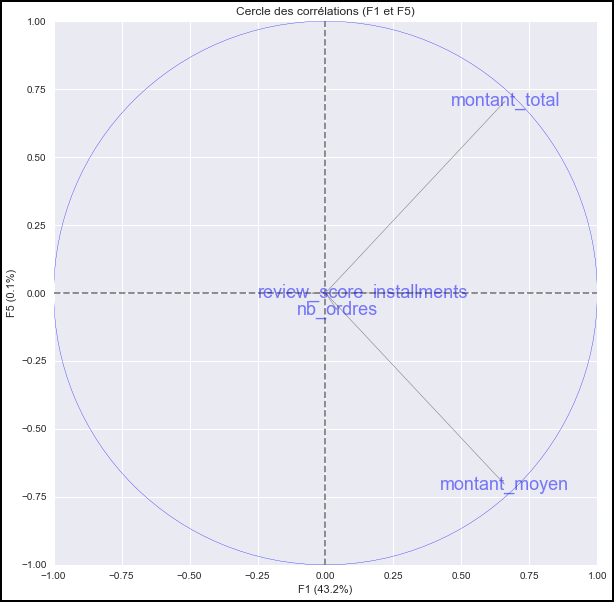

In [110]:
affichage_cercles_correlations(pca, features)

#### Affichage des clients sur les plans factoriels

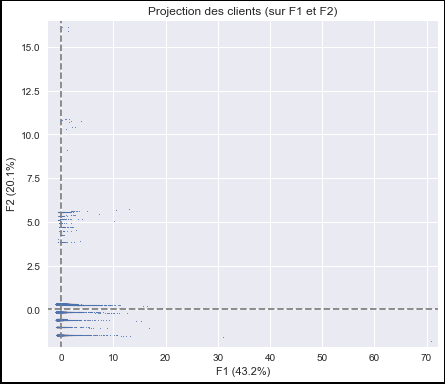

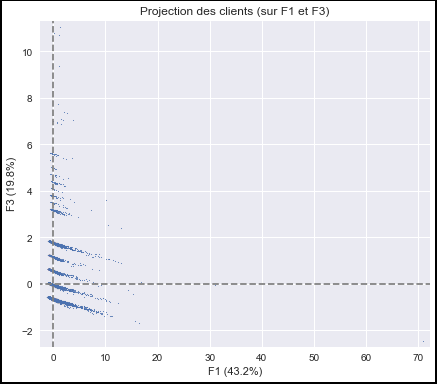

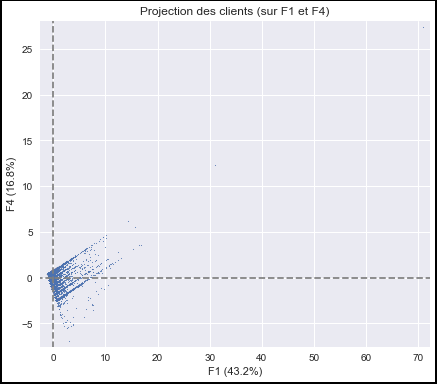

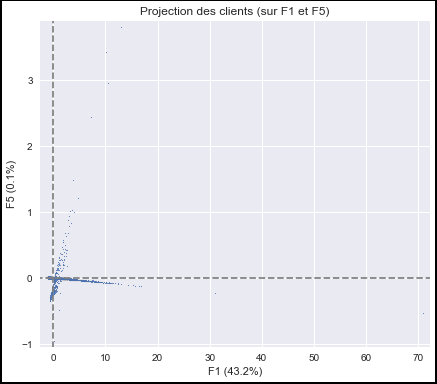

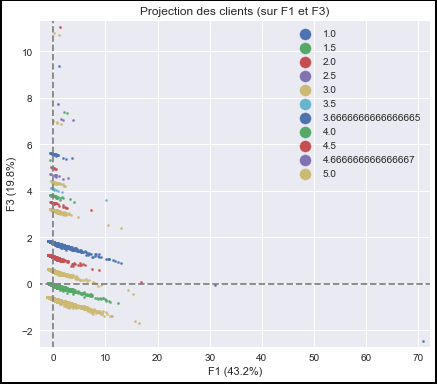

In [111]:
affichage_clients(pca, data_scaled_trim_3,
                  illustrative_var=data_trim_3['review_score'], 
                  axis_ranks=[(0, 2)])

Plan factoriel (F1, F4) : on observe 5 clusters (pour les 5 principales notes (1, 2, 3, 4, 5) du review score).

## Trimestre 4

### PCA

#### Calcul des composantes principales

In [112]:
features = data_trim_4.columns
pca = decomposition.PCA(n_components=len(features))
pca.fit(data_scaled_trim_4)

PCA(n_components=5)

#### Eboulis des valeurs propres

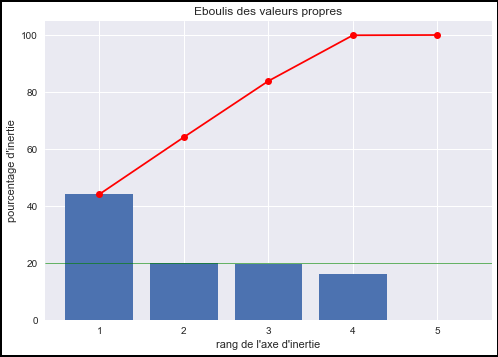

In [113]:
display_scree_plot(pca)

#### Cercles des corrélations

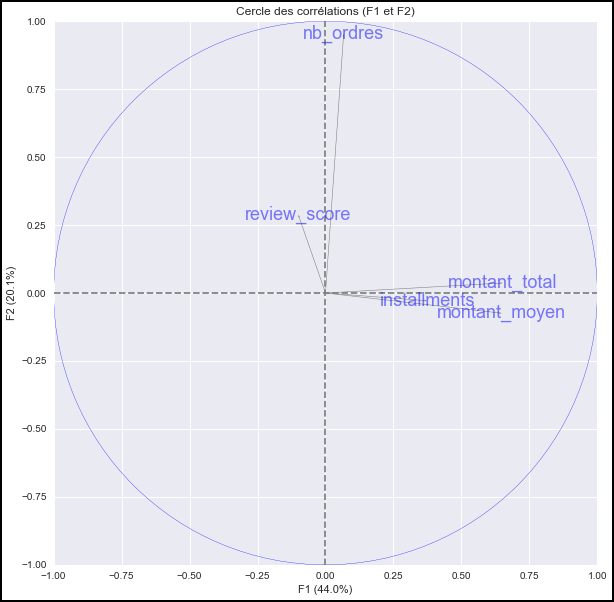

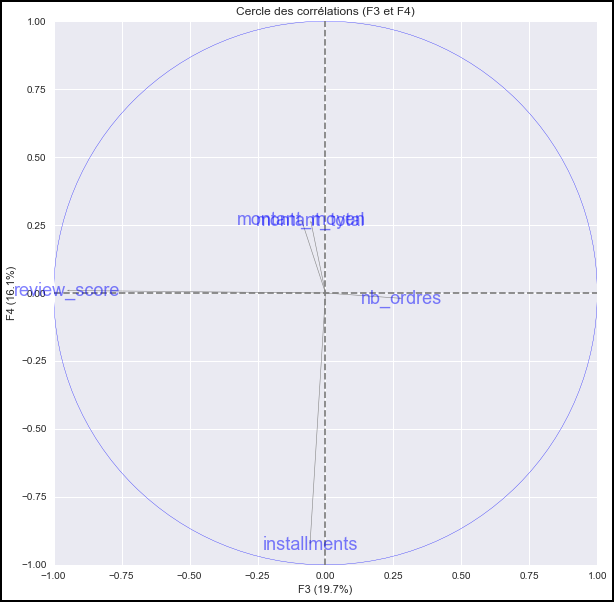

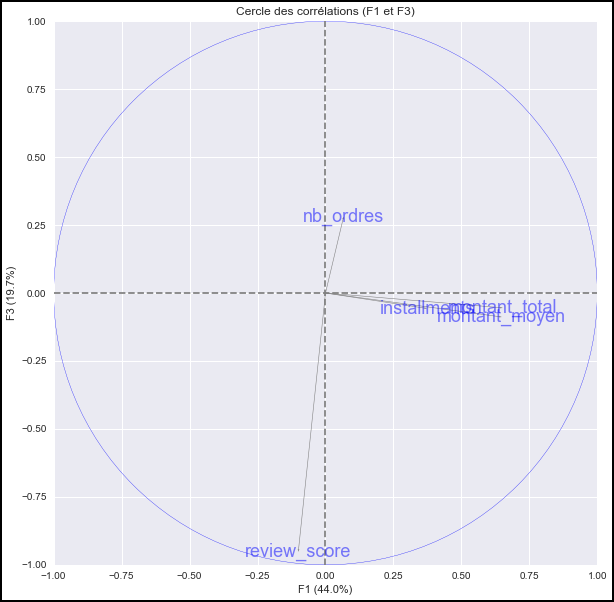

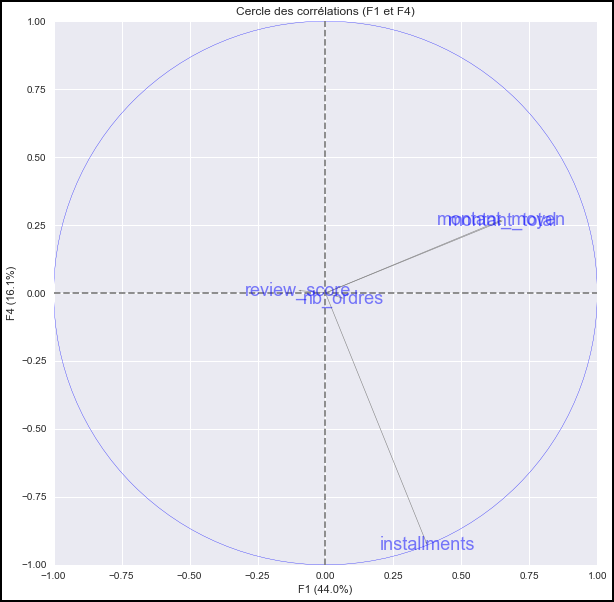

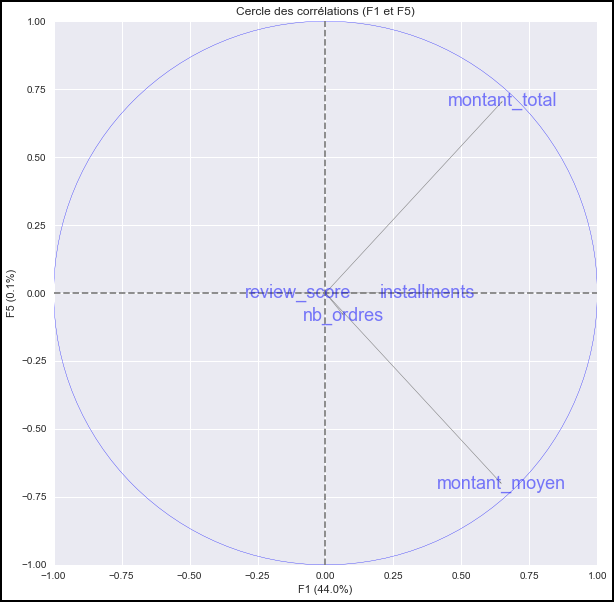

In [114]:
affichage_cercles_correlations(pca, features)

#### Affichage des clients sur les plans factoriels

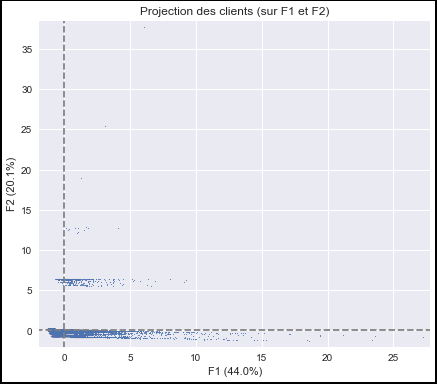

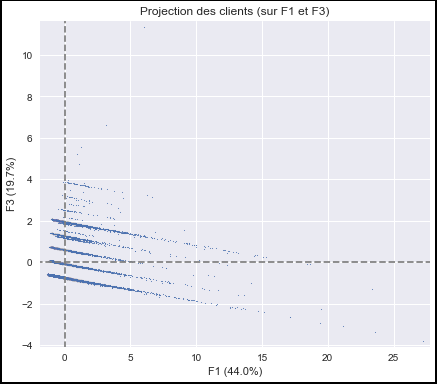

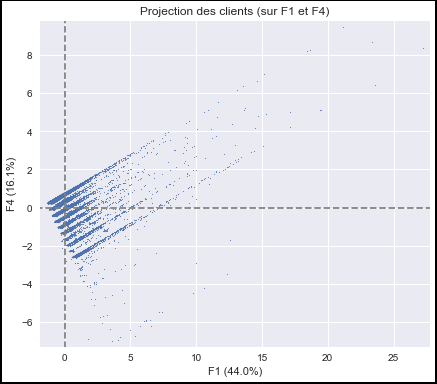

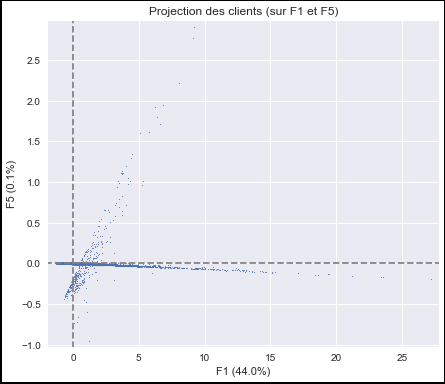

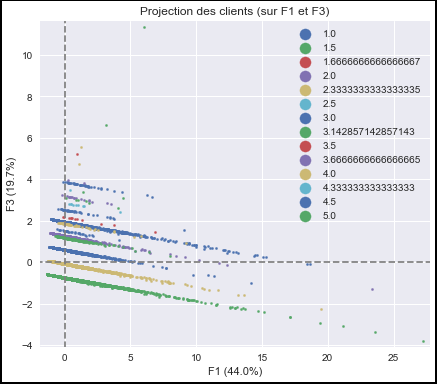

In [115]:
affichage_clients(pca, data_scaled_trim_4,
                  illustrative_var=data_trim_4['review_score'])

Plan factoriel (F1, F3) : on observe 5 clusters (pour les 5 principales notes (1, 2, 3, 4, 5) du review score).

### t-SNE

###### Variation de la perplexité

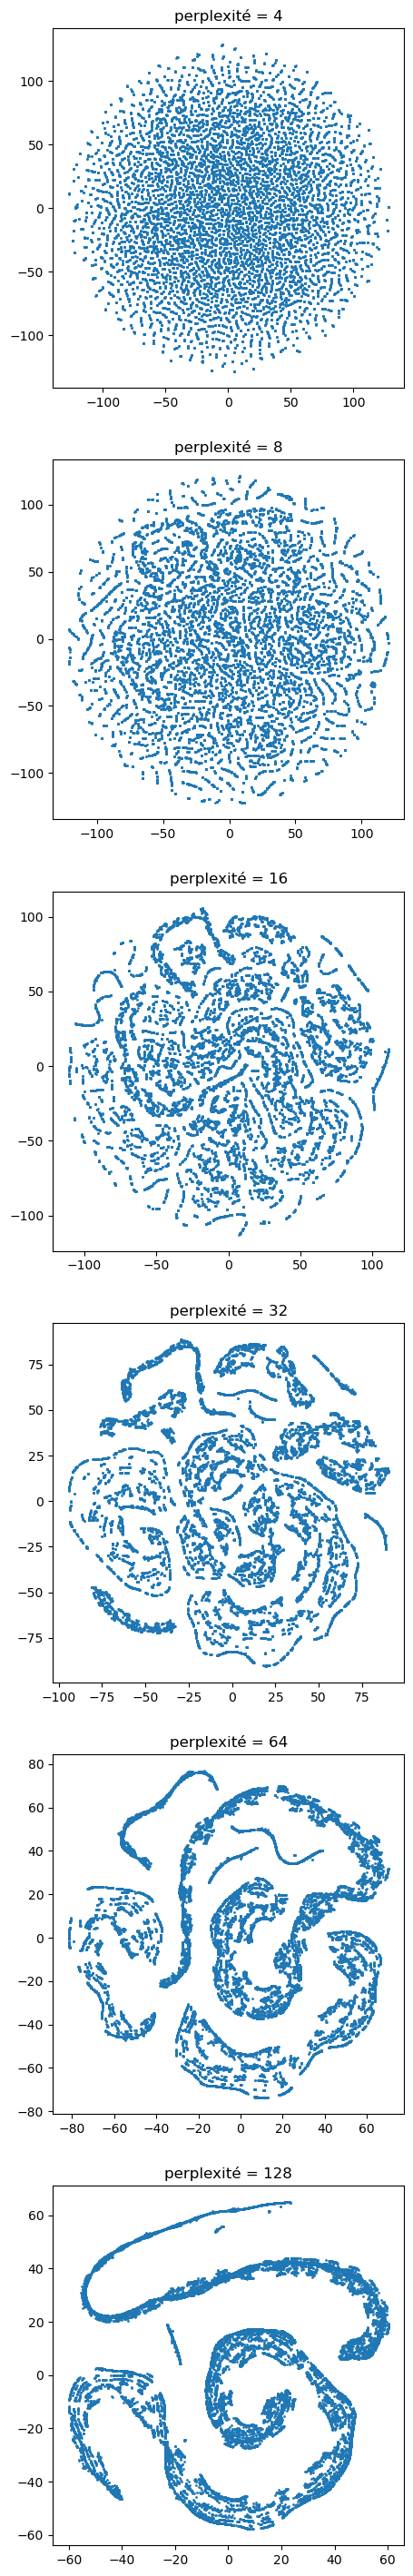

In [196]:
perplexities = [4, 8, 16, 32, 64, 128]
subplots = [611, 612, 613, 614, 615, 616]
plt.figure(figsize=(5, 6*len(perplexities)))

for subplot, perplexity in zip(subplots, perplexities):
    plt.subplot(subplot)
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    data_reduced_tsne = tsne.fit_transform(data_trim_4)
    plt.scatter(data_reduced_tsne[:, 0], data_reduced_tsne[:, 1], s=1)
    plt.title('perplexité = ' + str(perplexity), fontsize=12)
plt.show

## Trimestre 5

### PCA

#### Calcul des composantes principales

In [116]:
features = data_trim_5.columns
pca = decomposition.PCA(n_components=len(features))
pca.fit(data_scaled_trim_5)

PCA(n_components=5)

#### Eboulis des valeurs propres

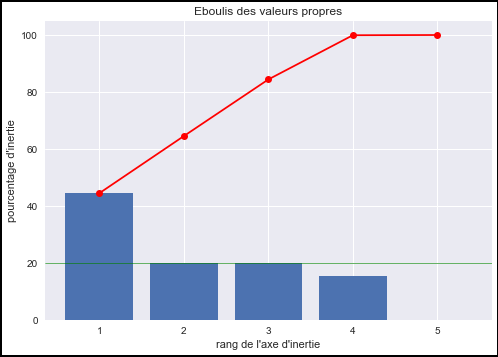

In [117]:
display_scree_plot(pca)

#### Cercles des corrélations

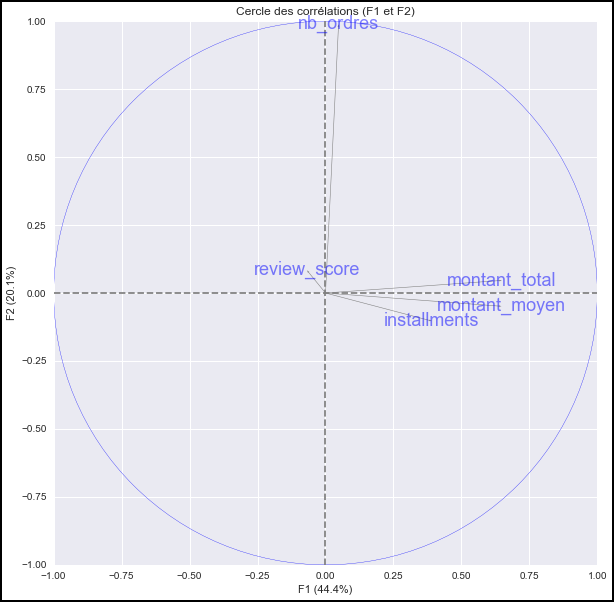

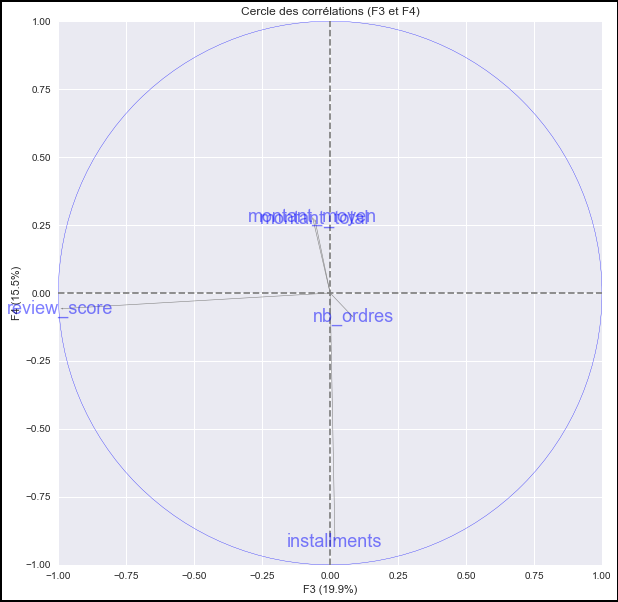

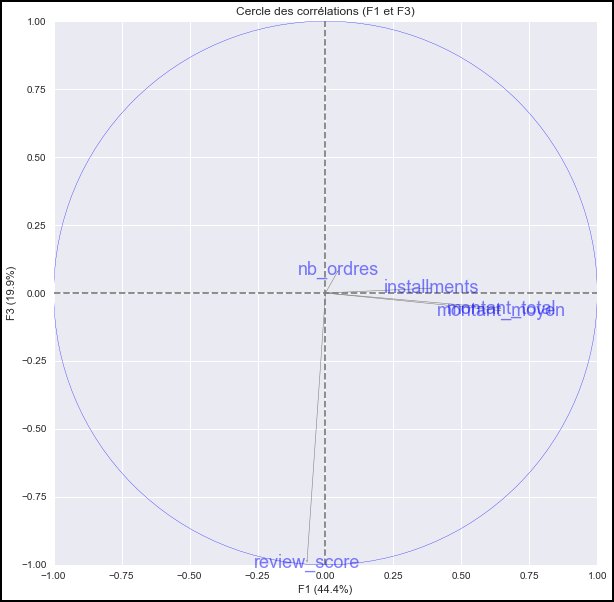

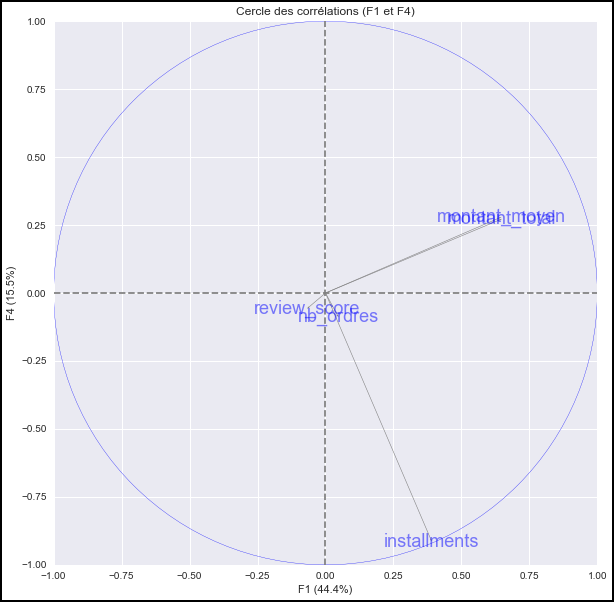

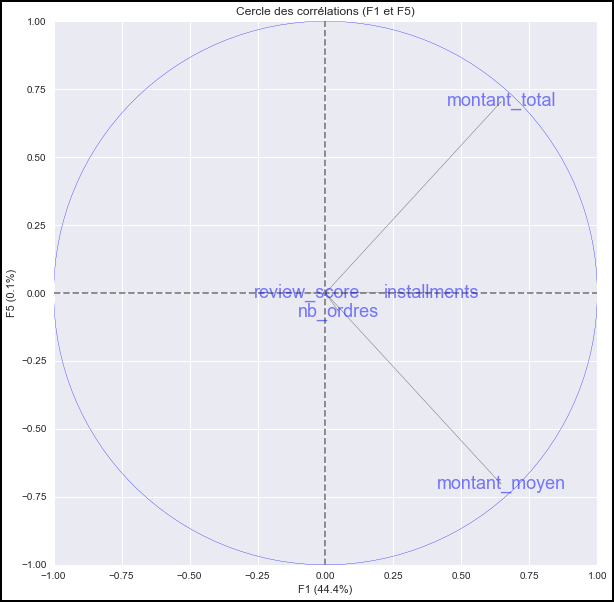

In [118]:
affichage_cercles_correlations(pca, features)

#### Affichage des clients sur les plans factoriels

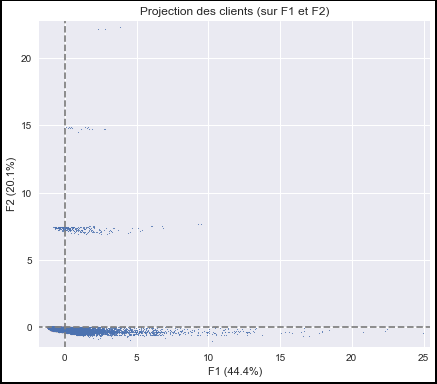

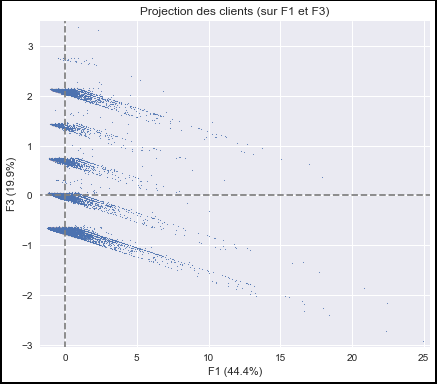

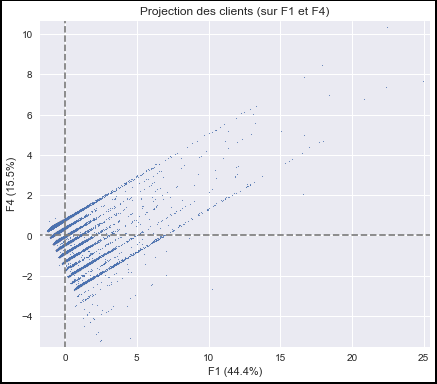

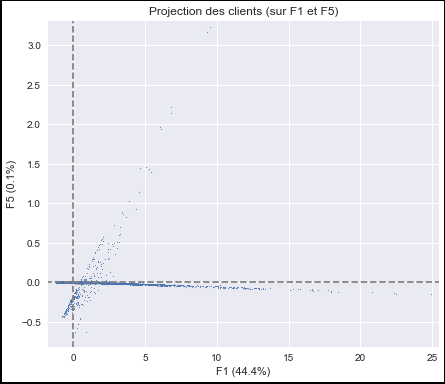

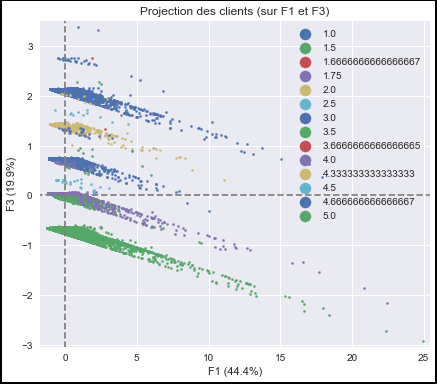

In [119]:
affichage_clients(pca, data_scaled_trim_5,
                  illustrative_var=data_trim_5['review_score'], 
                  axis_ranks=[(0, 2)])

Plan factoriel (F1, F4) : on observe 5 clusters (pour les 5 principales notes (1, 2, 3, 4, 5) du review score).

## Trimestre 6

### PCA

#### Calcul des composantes principales

In [120]:
features = data_trim_6.columns
pca = decomposition.PCA(n_components=len(features))
pca.fit(data_scaled_trim_6)

PCA(n_components=5)

#### Eboulis des valeurs propres

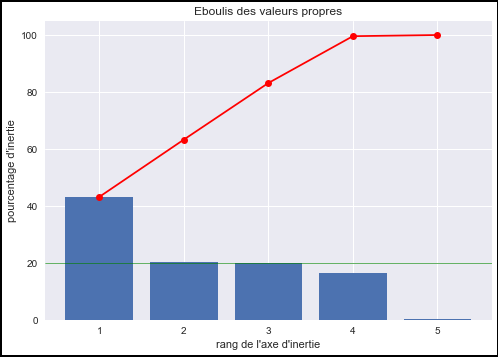

In [121]:
display_scree_plot(pca)

#### Cercles des corrélations

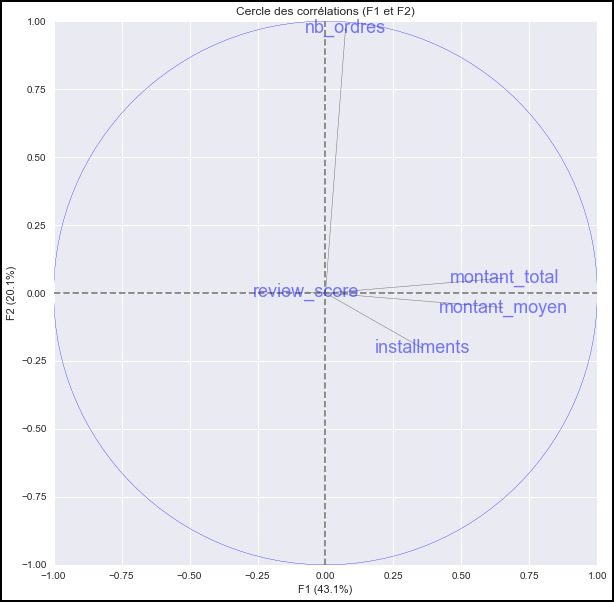

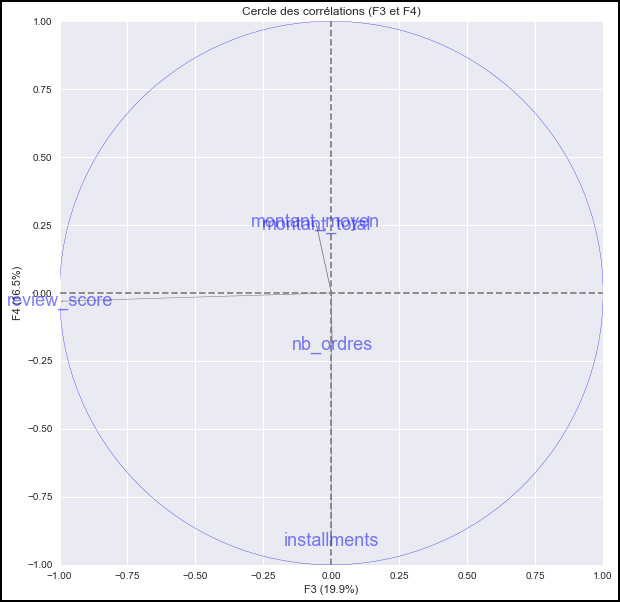

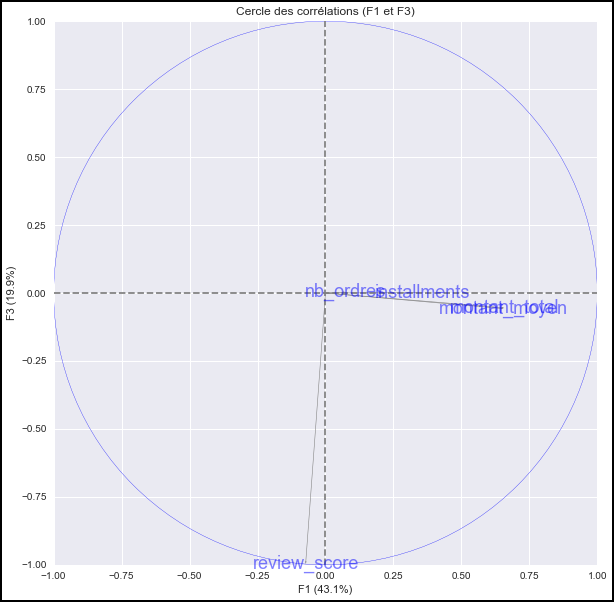

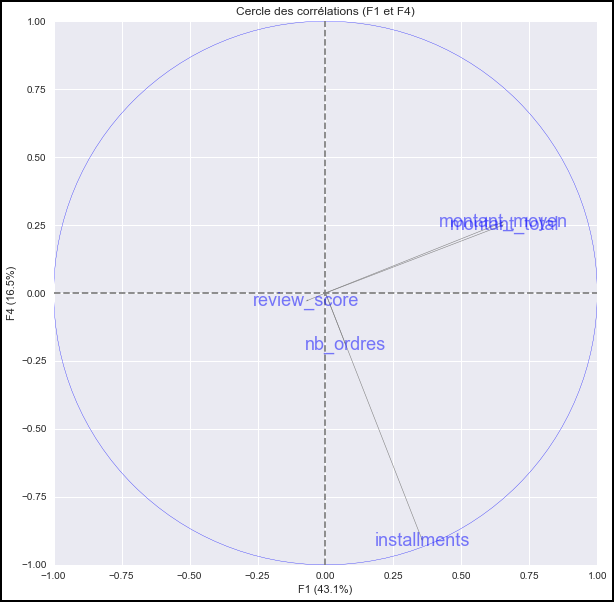

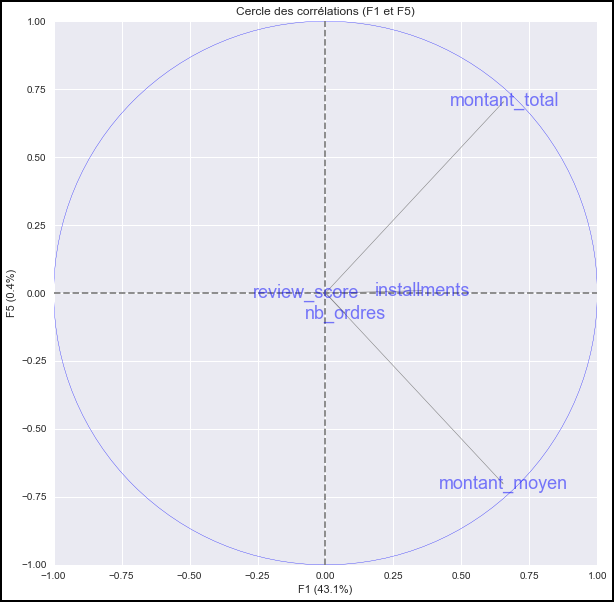

In [122]:
affichage_cercles_correlations(pca, features)

#### Affichage des clients sur les plans factoriels

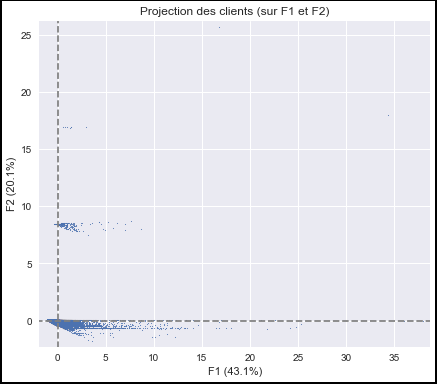

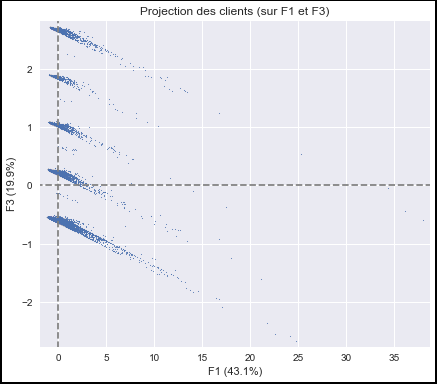

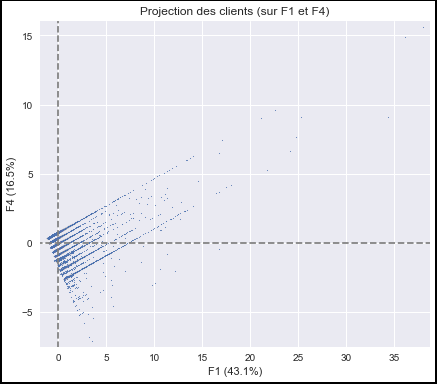

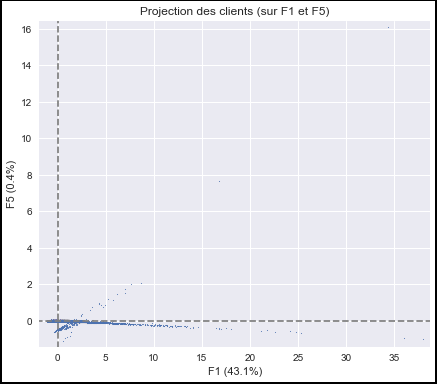

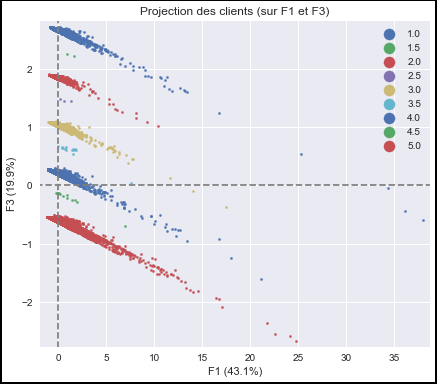

In [123]:
affichage_clients(pca, data_scaled_trim_6,
                  illustrative_var=data_trim_6['review_score'])

Plan factoriel (F1, F3) : on observe 5 clusters (pour les 5 principales notes (1, 2, 3, 4, 5) du review score).

# Sauvegarde des données utilisées pour l'apprentissage supervisé (pickle)

In [124]:
pickle.dump(data_trim, open('data_trim.pkl', 'wb'))
pickle.dump(data_scaled_trim, open('data_scaled_trim.pkl', 'wb'))